In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import itertools as it

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pandas as pd

class data_object(object):
    def __init__(self, name):
        self.name = name

In [2]:
plt.style.use('seaborn-poster')

In [3]:
with open('random_states_2.pickle','rb') as f:
    random_states = pickle.load(f)
random_states = {i:random_states[i] for i in random_states}

# First, let's take a look at solution statistics

In [4]:
total_runs = []
finished_initialization = []
finished_DDF = []
finished_gasoline = []
finished_diesel = []
finished_combined = []

with open('./log/master/master_log_19092018.txt','r') as f:
    for key, group in it.groupby(f,lambda line: line.startswith('------------')):
        if not key:
            run_data = list(group)

            # get run number
            start = 'Preset_Case:_'
            end = '_'
            s = run_data[2]
            run_case = int(s[s.find(start)+len(start):s.rfind(end)])
            total_runs.append(run_case)
            
            # get status
            if 'Success: > Initialization\n' in run_data:
                finished_initialization.append(True)
            else:
                finished_initialization.append(False)
                
            if 'Success: > Added DDF formulation\n' in run_data:
                finished_DDF.append(True)
            else:
                finished_DDF.append(False)
                
            if 'Success: > One-step Optimization - Gasoline\n' in run_data:
                finished_gasoline.append(True)
            else:
                finished_gasoline.append(False)
                
            if 'Success: > One-step Optimization - Diesel\n' in run_data:
                finished_diesel.append(True)
            else:
                finished_diesel.append(False)
                
            if 'Success: > One-step Optimization - Naphtha + Gasoline + Diesel\n' in run_data:
                finished_combined.append(True)
            else:
                finished_combined.append(False)
                
finished_initialization = np.array(finished_initialization)
finished_DDF = np.array(finished_DDF)
finished_gasoline = np.array(finished_gasoline)
finished_diesel = np.array(finished_diesel)
finished_combined = np.array(finished_combined)
finished_optimization_any = np.any([finished_gasoline,finished_diesel,finished_combined],axis=0)
finished_optimization_all = np.all([finished_gasoline,finished_diesel,finished_combined],axis=0)

In [5]:
reactive_stages = random_states[1].temperature_flag.keys()

In [6]:
def divide_data(x):
    x = np.array(x)
    return x, x[finished_initialization], x[finished_optimization_any]

## Total number of attempts

In [7]:
len(total_runs)

540

## Successfully initialized

In [8]:
sum(finished_initialization), sum(finished_initialization) / len(total_runs)

(481, 0.8907407407407407)

## Successfully adopted DDF formulation

In [9]:
sum(finished_DDF), sum(finished_DDF) / sum(finished_initialization)

(466, 0.9688149688149689)

## Successfully reached optimum solution

In [10]:
sum(finished_optimization_any), sum(finished_optimization_all)

(449, 219)

In [11]:
sum(finished_optimization_any) / sum(finished_DDF), sum(finished_optimization_all) / sum(finished_DDF)

(0.9635193133047211, 0.4699570815450644)

In [12]:
sum(finished_gasoline), sum(finished_diesel), sum(finished_combined)

(406, 315, 342)

In [13]:
sum(finished_gasoline) / sum(finished_DDF), sum(finished_diesel) / sum(finished_DDF), sum(finished_combined) / sum(finished_DDF)

(0.871244635193133, 0.6759656652360515, 0.7339055793991416)

# Different starting points doesn't seem to drastically affect success rate

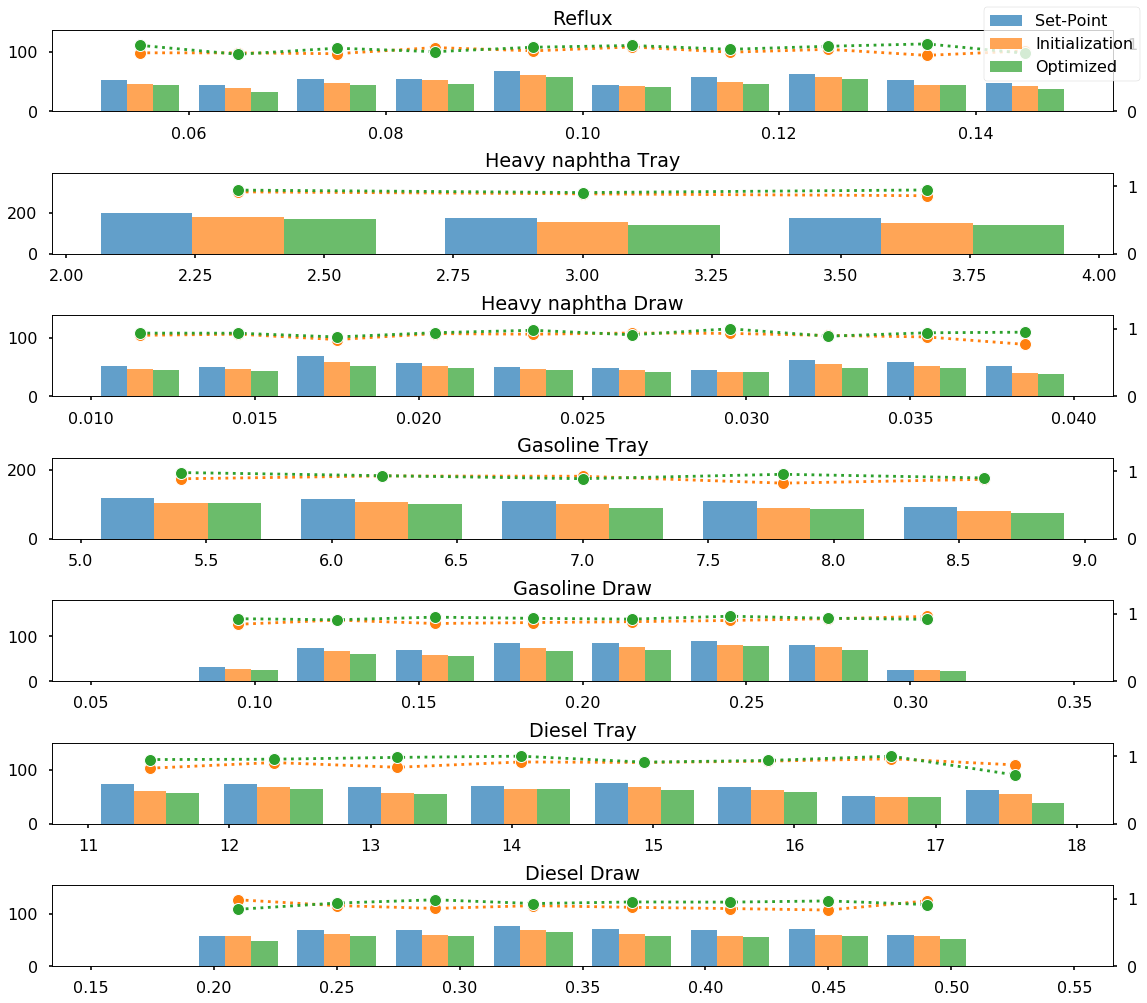

In [14]:
reflux_ratio_all = np.array([random_states[i].rr_ratio for i in random_states if i in total_runs])
intermediate_location_all = np.array([sorted(random_states[i].side_draw_flag.keys())[0] for i in random_states if i in total_runs])
intermediate_draw_all = np.array([list(random_states[i].side_draw_flag.values())[0] for i in random_states if i in total_runs])
gasoline_location_all = np.array([sorted(random_states[i].side_draw_flag.keys())[1] for i in random_states if i in total_runs])
gasoline_draw_all = np.array([list(random_states[i].side_draw_flag.values())[1] for i in random_states if i in total_runs])
diesel_location_all = np.array([sorted(random_states[i].side_draw_flag.keys())[2] for i in random_states if i in total_runs])
diesel_draw_all = np.array([list(random_states[i].side_draw_flag.values())[2] for i in random_states if i in total_runs])

fig, axs = plt.subplots(7,1,figsize=(16,14))

tmp_dic = {0:(reflux_ratio_all,'Reflux',(0.05,0.15),10),
          1:(intermediate_location_all,'Heavy naphtha Tray',(2,4),3),
          2:(intermediate_draw_all,'Heavy naphtha Draw',(0.01,0.04),10),
          3:(gasoline_location_all,'Gasoline Tray',(5,9),5),
          4:(gasoline_draw_all,'Gasoline Draw',(0.05,0.35),10),
          5:(diesel_location_all,'Diesel Tray',(11,18),8),
          6:(diesel_draw_all,'Diesel Draw',(0.15,0.55),10)}

for j in range(7):
    y, bins, patches = axs[j].hist((divide_data(tmp_dic[j][0])),bins=tmp_dic[j][3],histtype='bar',range=tmp_dic[j][2],alpha=0.7)
    ymax = max(y[0])
    axs[j].set_ylim(bottom=0,top=2*ymax)

    bincenters = 0.5*(bins[1:]+bins[:-1])
    ratio_init = [float('nan') if j==0 or i==0 else i/j for i,j in zip(y[1],y[0])]
    ratio_opt = [float('nan') if j==0 or i==0 else i/j for i,j in zip(y[2],y[1])]

    ax_ = plt.twinx(axs[j])
    ax_.plot(bincenters,ratio_init,'C1:o',markeredgecolor='w',markersize=12,markeredgewidth = 1)
    ax_.plot(bincenters,ratio_opt,'C2:o',markeredgecolor='w',markersize=12,markeredgewidth = 1)
    ax_.set_ylim(0,1.2)

    # ax.grid()
    axs[j].set_title(tmp_dic[j][1])

fig.legend(['Set-Point','Initialization','Optimized'])
plt.tight_layout()
plt.show()
plt.close()

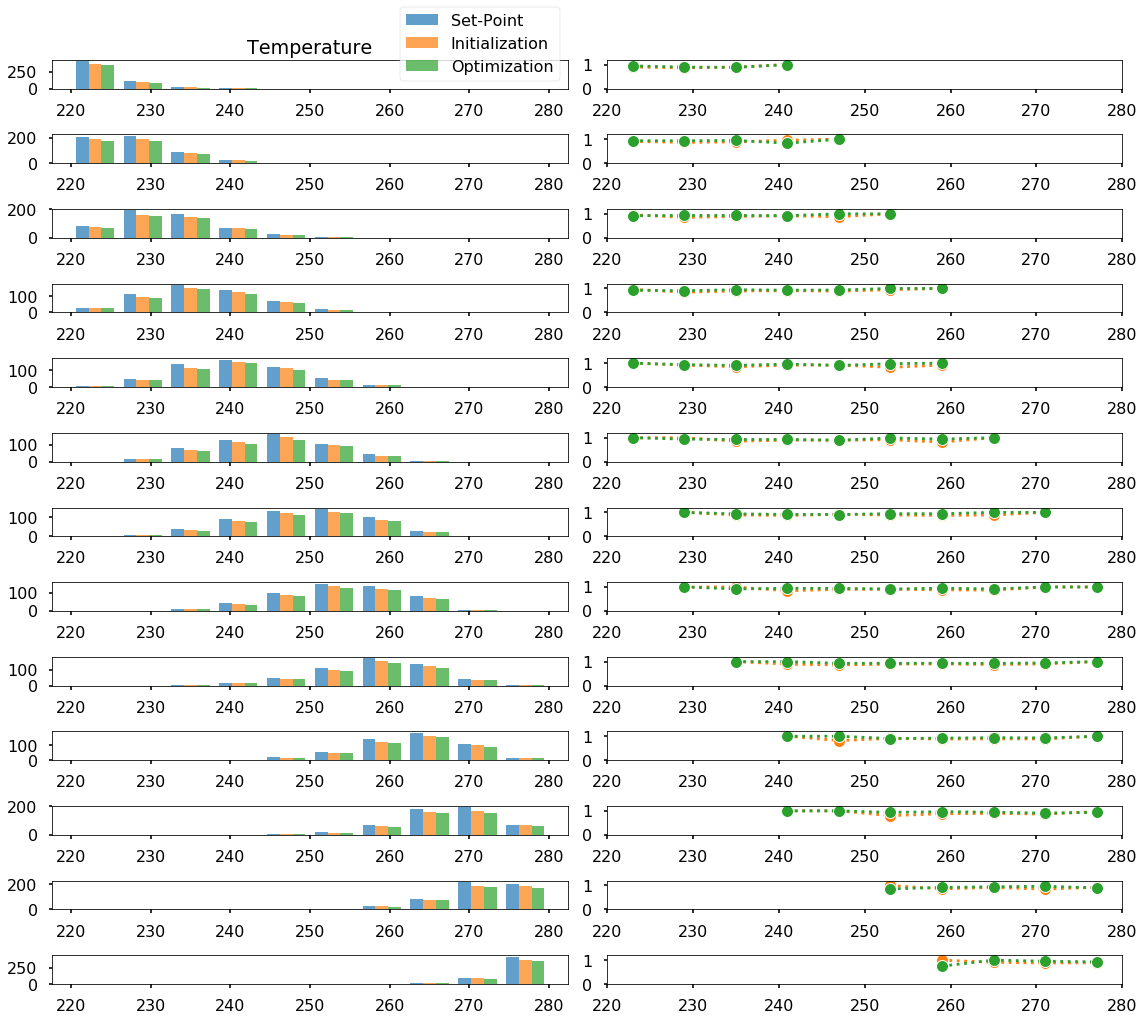

In [15]:
temperature_all = {j:np.array([random_states[i].temperature_flag[j] for i in random_states if i in total_runs])\
                   for j in reactive_stages}

fig, axs = plt.subplots(len(reactive_stages),2,figsize=(16,14))

for j_, j in enumerate(reactive_stages):
    y, bins, patches = axs[j_][0].hist(divide_data(temperature_all[j]),bins=10,histtype='bar',range=(220,280),alpha=0.7)
    ymax = max(y[0])
    # ax.set_ylim(bottom=0,top=2*ymax)

    bincenters = 0.5*(bins[1:]+bins[:-1])
    ratio_init = [float('nan') if j==0 or i==0 else i/j for i,j in zip(y[1],y[0])]
    ratio_opt = [float('nan') if j==0 or i==0 else i/j for i,j in zip(y[2],y[1])]

    axs[j_][1].plot(bincenters,ratio_init,'C1:o',markeredgecolor='w',markersize=12,markeredgewidth = 1)
    axs[j_][1].plot(bincenters,ratio_opt,'C2:o',markeredgecolor='w',markersize=12,markeredgewidth = 1)
    axs[j_][1].set_ylim(0,1.2)
    axs[j_][1].set_xlim(220,280)

axs[0][0].set_title('Temperature')
axs[0][0].legend(['Set-Point','Initialization','Optimization'])

plt.tight_layout()
plt.show()
plt.close()

# Strong 1-sided start seems to increase success rate

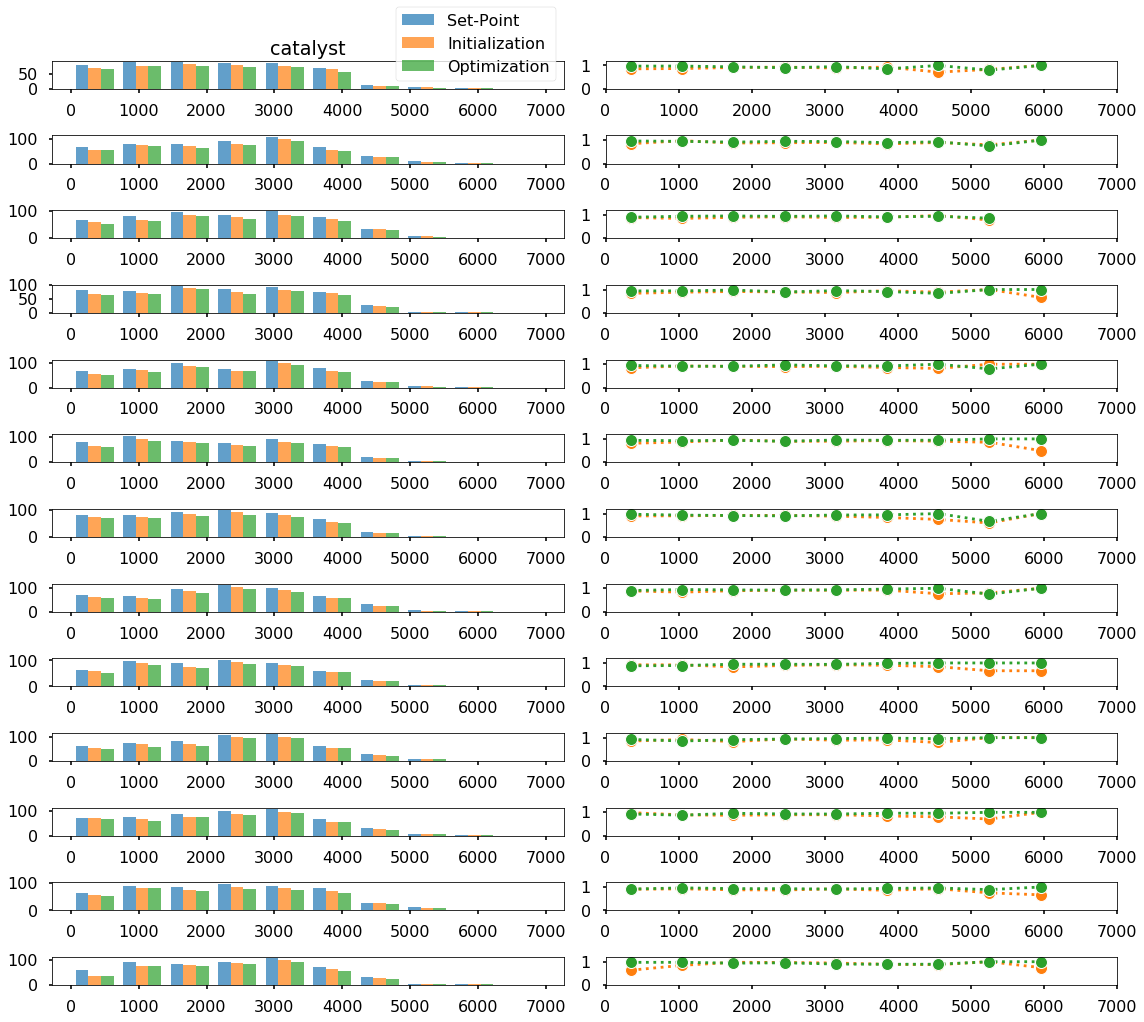

In [16]:
catalyst_all = {j:np.array([random_states[i].catalyst_flag[j] for i in random_states if i in total_runs])\
                   for j in reactive_stages}

fig, axs = plt.subplots(len(reactive_stages),2,figsize=(16,14))

for j_, j in enumerate(reactive_stages):
    y, bins, patches = axs[j_][0].hist(divide_data(catalyst_all[j]),bins=10,histtype='bar',range=(0,7000),alpha=0.7)
    ymax = max(y[0])
    # ax.set_ylim(bottom=0,top=2*ymax)

    bincenters = 0.5*(bins[1:]+bins[:-1])
    ratio_init = [float('nan') if j==0 or i==0 else i/j for i,j in zip(y[1],y[0])]
    ratio_opt = [float('nan') if j==0 or i==0 else i/j for i,j in zip(y[2],y[1])]

    axs[j_][1].plot(bincenters,ratio_init,'C1:o',markeredgecolor='w',markersize=12,markeredgewidth = 1)
    axs[j_][1].plot(bincenters,ratio_opt,'C2:o',markeredgecolor='w',markersize=12,markeredgewidth = 1)
    axs[j_][1].set_ylim(0,1.2)
    axs[j_][1].set_xlim(0,7000)

axs[0][0].set_title('catalyst')
axs[0][0].legend(['Set-Point','Initialization','Optimization'])

plt.tight_layout()
plt.show()
plt.close()

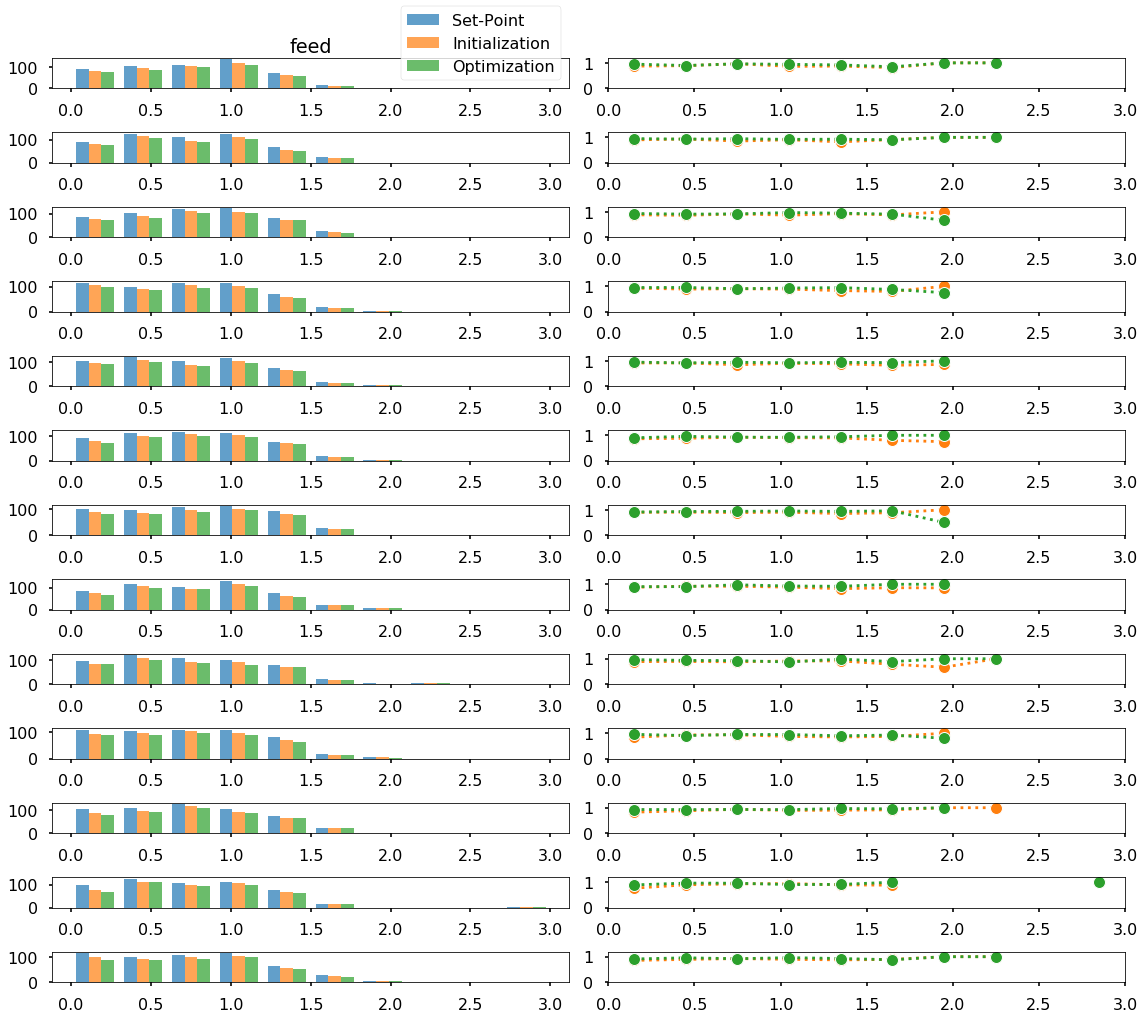

In [17]:
feed_all = {j:np.array([random_states[i].feed_flag[j] for i in random_states if i in total_runs])\
                   for j in reactive_stages}

fig, axs = plt.subplots(len(reactive_stages),2,figsize=(16,14))

for j_, j in enumerate(reactive_stages):
    y, bins, patches = axs[j_][0].hist(divide_data(feed_all[j]),bins=10,histtype='bar',range=(0,3),alpha=0.7)
    ymax = max(y[0])
    # ax.set_ylim(bottom=0,top=2*ymax)

    bincenters = 0.5*(bins[1:]+bins[:-1])
    ratio_init = [float('nan') if j==0 or i==0 else i/j for i,j in zip(y[1],y[0])]
    ratio_opt = [float('nan') if j==0 or i==0 else i/j for i,j in zip(y[2],y[1])]

    axs[j_][1].plot(bincenters,ratio_init,'C1:o',markeredgecolor='w',markersize=12,markeredgewidth = 1)
    axs[j_][1].plot(bincenters,ratio_opt,'C2:o',markeredgecolor='w',markersize=12,markeredgewidth = 1)
    axs[j_][1].set_ylim(0,1.2)
    axs[j_][1].set_xlim(0,3)

axs[0][0].set_title('feed')
axs[0][0].legend(['Set-Point','Initialization','Optimization'])

plt.tight_layout()
plt.show()
plt.close()

# Reduce dimension for visulization using PCA, uniform distribution, expect to yield little capture

In [18]:
x_data = np.stack((
    reflux_ratio_all,
    intermediate_location_all,
    intermediate_draw_all,
    gasoline_location_all,
    gasoline_draw_all,
    diesel_location_all,
    diesel_draw_all,
    *[temperature_all[j] for j in temperature_all],
    *[catalyst_all[j] for j in temperature_all],
    *[feed_all[j] for j in temperature_all]
),axis=1)

## 46 features

In [19]:
x_data.shape

(540, 46)

In [20]:
center_scaled = StandardScaler().fit_transform(x_data)
pca = PCA(n_components=10)
scores = pca.fit_transform(center_scaled)

### Eigenvalues

In [21]:
pca.explained_variance_

array([6.75883231, 2.55717775, 1.5695629 , 1.51616387, 1.49279194,
       1.40341629, 1.34956364, 1.3263521 , 1.30161337, 1.23833764])

### Captured Covariance

In [22]:
pca.explained_variance_ratio_

array([0.14665904, 0.05548787, 0.03405775, 0.03289905, 0.0323919 ,
       0.03045255, 0.02928401, 0.02878035, 0.02824354, 0.02687053])

### Loadings - PC1 - Mostly independent, except temperature, which have same signs, meaning one temperature increases, the other ones increases, this response is modelled by sorting temperature from low to high

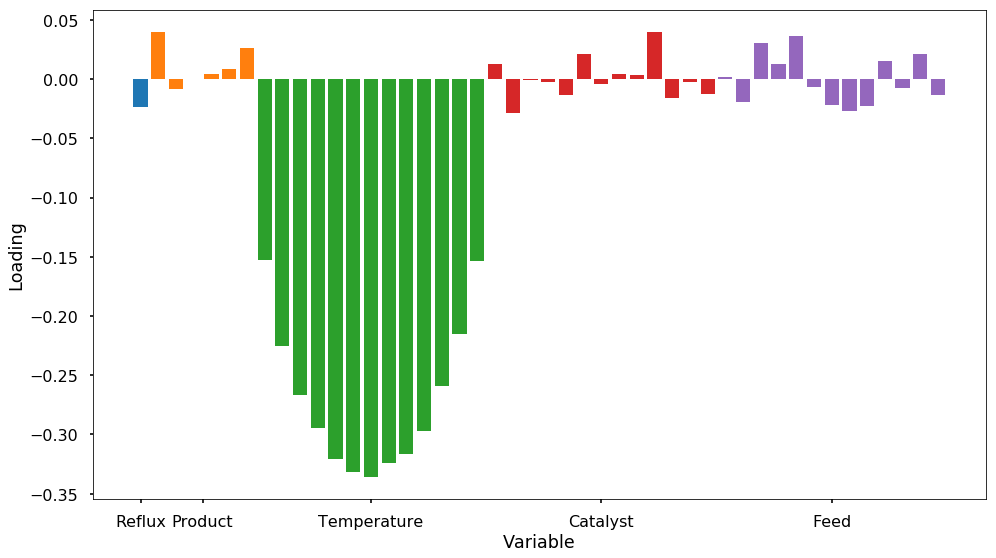

In [23]:
fig, axs = plt.subplots(figsize=(16,9))
x_loc = np.arange(1,len(pca.components_[0])+1)
grouping = {'Reflux':slice(0,1),'Product':slice(1,7),'Temperature':slice(7,20),\
            'Catalyst':slice(20,33),'Feed':slice(33,None)}

for key in grouping:
    axs.bar(x_loc[grouping[key]],pca.components_[0][grouping[key]])
axs.set_xticks([1,4.5,14,27,40])
axs.set_xticklabels(list(grouping.keys()))

axs.set_xlabel('Variable')
axs.set_ylabel('Loading')
plt.show()
plt.close()

### Scores - Success rate is not biased towards certain combination, uniform distributed set of initialized solutions for optimization multi-start

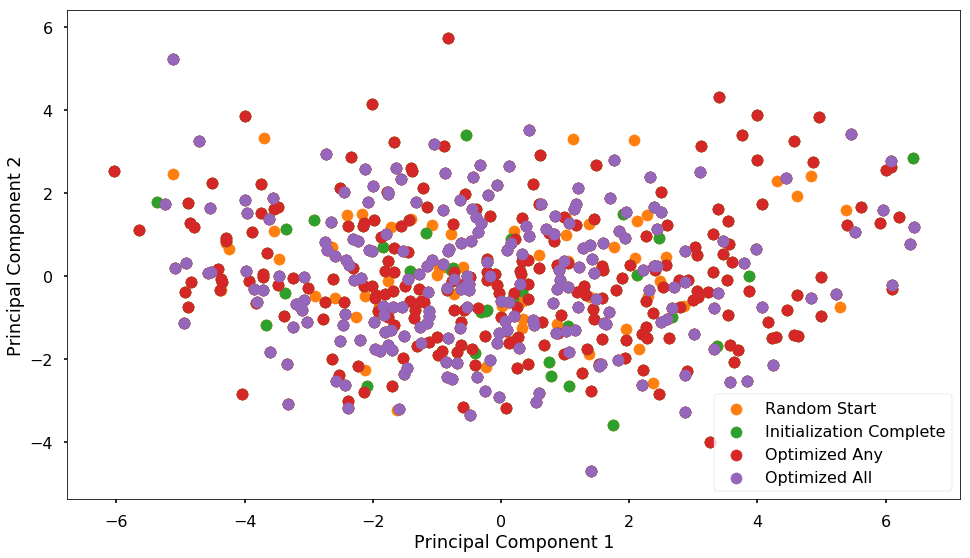

In [24]:
fig, axs = plt.subplots(figsize=(16,9))

targets = ['Random Start', 'Initialization Complete', 'Optimized Any', 'Optimized All']
colors = ['C1', 'C2', 'C3','C4']
masks = {'Random Start':True,\
         'Initialization Complete':finished_initialization,\
         'Optimized Any':finished_optimization_any,\
         'Optimized All':finished_optimization_all}

for target, color in zip(targets,colors):
    mask = masks[target]
    axs.scatter(scores[:,0][mask],scores[:,1][mask],color=color,label=target)

axs.legend()
axs.set_xlabel('Principal Component 1')
axs.set_ylabel('Principal Component 2')

plt.show()
plt.close()

# Second, let's take a look at cause of failure and performance

In [25]:
timing_list = []
failure_cause_list = []

for j in total_runs:
# if not finished_DDF[j-1]:
    file_name = 'mul_onestep_Preset_Case:_{}_NCP.dat'.format(j)
    with open('./log/text/'+file_name) as f:
        log_content = f.readlines()
        count = 0
        for line in reversed(log_content):
            if line.startswith('Total time:   '):
                if count == 0: 
                    count += 1
                    total_time = line.replace('Total time:   ','')
                    total_seconds = sum(x*int(t) for x,t in zip([3600,60,1],total_time.split(':')))
                    timing_list.append(total_seconds)
                else:
                    pass
            if line.startswith('>') or 'Working on' in line:
                break_cause = line.replace('> ','')
                failure_cause_list.append(break_cause)
                break

### Combine failure causes

In [26]:
failure_short = []
for line in failure_cause_list:
    if 'temperature' in line:
        start = 'Working on adjusting '
        end = 'temperature'
        failure_short.append(line[line.find(start) + len(start) : line.rfind(end)] + 'Temp')
    elif 'changing Q' in line:
        start = 'Working on '
        end = ','
        failure_short.append(line[line.find(start) + len(start) : line.rfind(end)] + ' duty') 
    elif 'feed' in line:
        start = 'feed from '
        end = ':'
        failure_short.append(line[line.find(start) + len(start) : line.rfind(end)] + ' feed/catalyst')
    elif 'DDF' in line:
        failure_short.append('Added 3 DDF')
    else:
        failure_short.append(line.replace('\n',''))

In [27]:
failure_counts = Counter(failure_short)
for keys in list(failure_counts.keys()):
    if keys.startswith('One-step Optimization'):
        failure_counts.pop(keys,None);
failure_counts = sorted(dict(failure_counts).items(),key=lambda x: (x[0].split(' ')[-1],int(x[0].split(' ')[1])),reverse=False)
failure_dic = {}
for key, group in it.groupby(failure_counts,lambda pair: pair[0].split()[-1]):
    failure_dic[key] = list(group)

In [28]:
sum(i[1] for i in failure_counts)

76

In [29]:
failure_counts

[('Added 3 DDF', 17),
 ('stage 11 Temp', 1),
 ('stage 13 Temp', 2),
 ('stage 17 Temp', 1),
 ('stage 20 Temp', 1),
 ('stage 1 duty', 2),
 ('stage 2 duty', 1),
 ('stage 6 duty', 2),
 ('stage 16 feed/catalyst', 2),
 ('stage 17 feed/catalyst', 1),
 ('stage 18 feed/catalyst', 10),
 ('stage 19 feed/catalyst', 28),
 ('stage 20 feed/catalyst', 8)]

## Initialization failures seem to happen near the bottom stage, largely independent of design specifications, definitely could be further improved

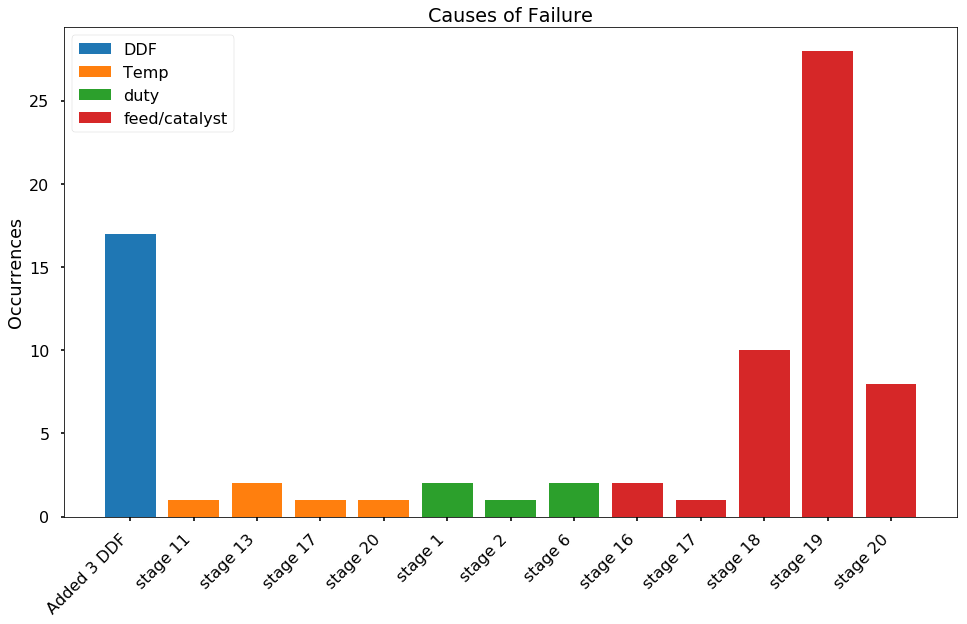

In [30]:
fig, axs = plt.subplots(figsize=(16,9))
loc = 0
names = []
for key in failure_dic.keys():
    frequencies = [j for i,j in failure_dic[key]]
    names += [i[:i.rfind(' ')] if 'DDF' not in i else i for i,j in failure_dic[key]]

    x_coordinates = np.arange(loc,len(failure_dic[key])+loc)
    axs.bar(x_coordinates, frequencies, align='center',label = key)
    loc += len(failure_dic[key])

axs.set_xticks(np.arange(loc))
axs.set_xticklabels(names,rotation=45,ha='right')

axs.set_ylabel('Occurrences')
axs.legend()
axs.set_title('Causes of Failure')
plt.show()

## Optimization Failure

In [31]:
gasoline_fail_list = []
diesel_fail_list = []
combined_fail_list = []

for j_,j in enumerate(total_runs):
    if finished_DDF[j_] and not finished_gasoline[j_]:
        file_name = 'mul_onestep_Preset_Case:_{}_NCP.dat'.format(j)
        with open('./log/text/'+file_name) as f:
            log_content = f.readlines()
            counter_gasoline = 0
            
            for line in reversed(log_content):
                if line.startswith('> One-step Optimization - Diesel'):
                    counter_gasoline = 1
                if counter_gasoline != 1:
                    continue
                if line.startswith('EXIT:'):
#                     if 'Optimal Solution Found' in line:
#                         gasoline_fail_list.append('Restoration Failed')
#                     else:
                    gasoline_fail_list.append(line.replace('EXIT: ','').replace('\n',''))
                    break

for j_,j in enumerate(total_runs):
    if finished_DDF[j_] and not finished_diesel[j_]:
        file_name = 'mul_onestep_Preset_Case:_{}_NCP.dat'.format(j)
        with open('./log/text/'+file_name) as f:
            log_content = f.readlines()
            counter_diesel = 0
            
            for line in reversed(log_content):
                if line.startswith('> One-step Optimization - Naphtha + Gasoline + Diesel'):
                    counter_diesel = 1
                if counter_diesel != 1:
                    continue
                if line.startswith('EXIT:'):
#                     if 'Optimal Solution Found' in line:
#                         diesel_fail_list.append('Restoration Failed')
#                     else:
                    diesel_fail_list.append(line.replace('EXIT: ','').replace('\n',''))
                    break

for j_,j in enumerate(total_runs):
    if finished_DDF[j_] and not finished_combined[j_]:
        file_name = 'mul_onestep_Preset_Case:_{}_NCP.dat'.format(j)
        with open('./log/text/'+file_name) as f:
            log_content = f.readlines()
            counter_diesel = 0
            
            for line in reversed(log_content):
                if line.startswith('EXIT:'):
                    if 'Optimal Solution Found' in line:
                        combined_fail_list.append('Restoration Failed')
                    else:
                        combined_fail_list.append(line.replace('EXIT: ','').replace('\n',''))
                    break

In [32]:
Counter(gasoline_fail_list), Counter(diesel_fail_list), Counter(combined_fail_list)

(Counter({'Maximum Number of Iterations Exceeded.': 58}),
 Counter({'Maximum Number of Iterations Exceeded.': 138,
          'Converged to a point of local infeasibility. Problem may be infeasible.': 3}),
 Counter({'Maximum Number of Iterations Exceeded.': 115,
          'Restoration Failed': 8,
          'Converged to a point of local infeasibility. Problem may be infeasible.': 1}))

# Lastly, optimization results, Gasoline

In [33]:
obj_list = []
opt_results = []
opt_origin_results = []

for j_,j in enumerate(total_runs):
    if finished_gasoline[j_]:
        file_name = 'mul_onestep_Preset_Case:_{}_NCP.dat'.format(j)
        with open('./log/text/'+file_name) as f:
            log_content = f.readlines()
            counter = 0
            
            for j, line in enumerate(reversed(log_content)):
                # get the right position, i know it is bad coding, but dont want make too much changes to the old code
                if '> One-step Optimization - Gasoline' in line:
                    starter_position = j - 50            
            
            
            for j, line in enumerate(reversed(log_content)):

                if j <= starter_position:
                    continue
                
                if line.startswith('gasoline'):
                    start = 'Wet flow  :'
                    end = 'Dry flow'
                    string = line[line.find(start)+len(start):line.rfind(end)]
                    string = string.strip()
                    obj_list.append(float(string))
                    break
            opt_results.append(log_content[-j-30:-j-29]+log_content[-j-20:-j-7]+log_content[-j-1:-j+1])
            opt_origin_results.append(log_content[-j-80:-j-79]+log_content[-j-70:-j-57]+log_content[-j-51:-j-49])
            
opt_results = [[data.split() for data in case] for case in opt_results]
opt_origin_results = [[data.split() for data in case] for case in opt_origin_results]

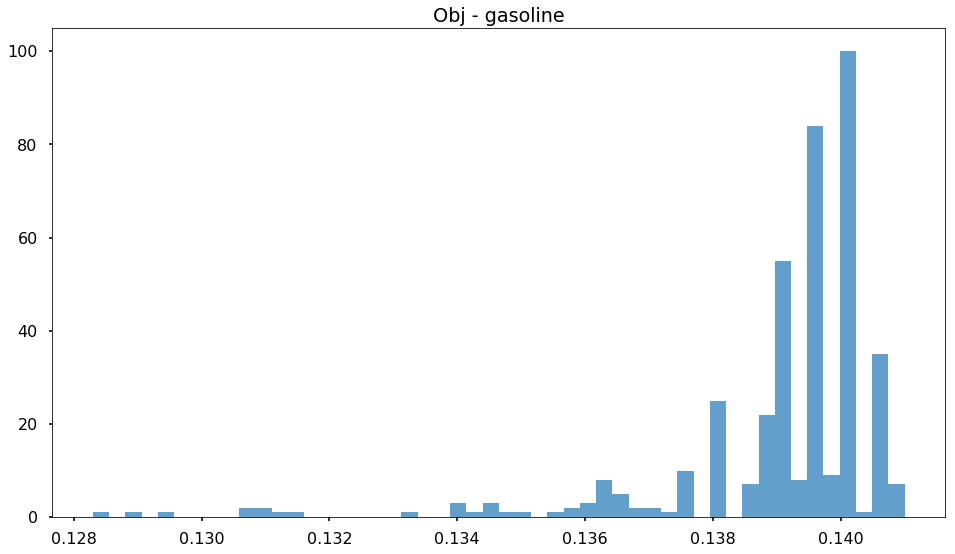

In [34]:
fig, axs = plt.subplots(figsize=(16,9))
y, bins, patches = axs.hist(obj_list,bins=50,histtype='bar',alpha=0.7)

axs.set_title('Obj - gasoline')
plt.show()

### Remove duplicates and sort

In [35]:
opt_results_matrix = np.stack((
    [float(case[0][4])/float(case[0][5]) for case in opt_results],
    [float(case[-3][-1]) for case in opt_results],
    [float(case[-3][6]) for case in opt_results],
    [float(case[-2][-1]) for case in opt_results],
    [float(case[-2][6]) for case in opt_results],
    [float(case[-1][-1]) for case in opt_results],
    [float(case[-1][6]) for case in opt_results],
    *np.array([[float(obv[1]) for obv in case[1:14]] for case in opt_results]).T,
    *np.array([[float(obv[6]) for obv in case[1:14]] for case in opt_results]).T,
    *np.array([[float(obv[5]) for obv in case[1:14]] for case in opt_results]).T
),axis=1)

In [36]:
opt_origin_matrix = np.stack((
    [float(case[0][4])/float(case[0][5]) for case in opt_origin_results],
    [float(case[-3][-1]) for case in opt_origin_results],
    [float(case[-3][6]) for case in opt_origin_results],
    [float(case[-2][-1]) for case in opt_origin_results],
    [float(case[-2][6]) for case in opt_origin_results],
    [float(case[-1][-1]) for case in opt_origin_results],
    [float(case[-1][6]) for case in opt_origin_results],
    *np.array([[float(obv[1]) for obv in case[1:14]] for case in opt_origin_results]).T,
    *np.array([[float(obv[6]) for obv in case[1:14]] for case in opt_origin_results]).T,
    *np.array([[float(obv[5]) for obv in case[1:14]] for case in opt_origin_results]).T
),axis=1)

In [37]:
opt_results_unique_unsorted, unique_index, unique_counts = np.unique(opt_results_matrix,axis=0,return_index=True,return_counts=True)

In [38]:
unique_global_index = [np.array(total_runs)[finished_gasoline][j] for j in unique_index]
opt_results_unique = np.array(sorted(opt_results_unique_unsorted,key=lambda x: x[4]))

In [39]:
pd.options.display.precision = 4
pd.DataFrame(sorted([i for i in zip(opt_results_unique_unsorted[:,4],unique_counts,unique_global_index)],\
                    key=lambda x: x[0]),columns=['Objective Value','Occurances','Example Index'])

,Objective Value,Occurances,Example Index
0,0.1283,1,423
1,0.1289,1,24
2,0.1295,1,740
3,0.1306,1,406
4,0.1306,1,708
5,0.1310,1,465
6,0.1310,1,237
7,0.1311,1,229
8,0.1315,1,720
9,0.1332,1,809


### Raw Data

In [40]:
pd.options.display.expand_frame_repr = False
pd.options.display.max_colwidth = 80000
pd.options.display.max_columns = None
pd.options.display.max_rows = 80000

In [41]:
pd.options.display.precision = 0
pd.DataFrame(opt_results_unique[:,7:20].T,index=['Tem{}'.format(j) for j in range(8,21)])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86
Tem8,200,200,200,234,234,200,200,200,235,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200
Tem9,200,200,200,200,200,200,200,200,200,238,237,238,238,237,237,237,238,237,237,238,238,238,238,238,238,238,238,238,238,239,238,239,238,238,237,239,239,239,239,239,239,238,238,239,238,238,238,239,238,238,238,238,238,238,238,238,237,238,228,238,237,238,228,238,239,227,238,228,238,238,237,238,238,227,227,227,238,238,237,226,238,237,238,227,237,237,237
Tem10,200,200,200,238,238,200,200,200,238,239,234,224,238,237,232,236,223,224,237,236,236,236,237,237,237,236,236,236,236,236,235,235,237,236,237,235,236,236,235,235,235,237,237,235,237,237,237,235,237,237,237,237,237,237,237,237,224,221,238,237,237,237,238,237,237,237,237,238,237,237,237,237,237,238,238,237,237,237,236,237,237,237,237,237,237,236,237
Tem11,238,238,240,235,235,239,239,239,235,239,248,238,269,281,245,244,237,237,238,229,227,230,235,235,235,217,224,224,224,220,214,200,235,219,236,200,200,200,200,200,200,235,235,200,234,234,234,200,234,234,234,236,236,236,236,236,237,237,237,234,236,236,237,236,234,237,234,237,234,234,236,236,234,237,237,237,236,236,236,237,236,236,236,237,236,236,236
Tem12,274,237,236,200,200,238,238,238,200,259,237,247,238,300,300,300,246,247,287,241,239,242,212,212,212,230,235,235,235,232,228,200,235,231,235,218,222,200,200,200,200,210,210,200,200,200,201,200,200,200,200,234,234,234,234,234,236,234,236,200,236,234,234,234,200,236,200,236,200,200,235,234,200,236,236,236,234,234,235,236,236,235,234,236,235,235,235
Tem13,300,245,200,226,226,235,235,235,230,234,249,237,258,236,236,236,237,237,300,266,266,272,255,255,255,238,243,243,242,240,237,239,217,240,220,230,232,200,200,200,200,201,201,226,223,223,224,227,225,223,223,222,222,222,222,222,234,210,234,226,234,222,200,222,228,236,228,234,228,228,233,222,229,234,236,235,223,223,235,236,234,233,223,235,235,235,233
Tem14,237,300,227,228,228,221,221,223,232,248,236,235,234,236,236,234,236,236,236,234,234,236,243,243,243,262,237,237,237,234,266,237,250,264,255,231,237,236,236,225,225,240,240,227,224,224,200,228,226,224,224,223,223,223,223,223,224,225,224,227,227,226,228,227,230,234,229,224,230,230,227,228,230,224,234,233,229,229,233,235,227,227,230,233,233,233,227
Tem15,236,237,240,237,237,232,232,233,232,239,235,236,249,234,234,235,234,235,234,239,239,234,300,300,300,234,234,234,234,243,253,300,242,236,244,234,262,235,235,234,234,237,237,228,237,237,237,229,236,237,237,241,241,240,240,240,222,226,224,228,226,227,229,227,230,228,229,228,230,230,228,229,230,230,228,228,230,230,229,233,230,230,230,228,233,229,230
Tem16,235,236,236,236,236,233,233,234,232,300,234,300,239,233,234,234,234,234,234,236,234,234,300,300,300,239,234,234,238,238,248,300,300,235,300,239,236,300,300,235,235,300,300,233,236,236,236,230,236,236,236,238,238,238,238,238,240,236,240,235,241,237,230,237,230,227,229,229,230,230,228,229,230,230,230,229,230,230,230,230,230,230,231,230,232,231,230
Tem17,234,234,200,200,200,237,237,234,233,300,234,200,300,200,200,200,200,234,234,200,235,235,300,300,300,236,236,236,234,235,234,300,300,238,300,236,235,300,300,200,300,300,300,234,200,300,200,233,200,300,200,300,300,200,200,300,238,236,238,235,238,236,234,236,234,240,234,236,230,230,237,235,231,230,229,228,230,230,229,231,230,230,231,230,231,230,231


In [42]:
pd.options.display.precision = 0
pd.DataFrame(opt_results_unique[:,20:33].T,index=['Catalyst {}'.format(j) for j in range(8,21)])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86
Catalyst 8,10,10,10,9142,9146,10,10,10,10146,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
Catalyst 9,10,10,10,10,10,10,10,10,10,2524,16800,18481,3725,8028,12462,8483,18212,17796,7836,11155,11389,10530,7854,7882,7893,11681,10950,10959,10898,11776,11661,11626,9018,10911,6763,11946,11445,12090,11849,12014,12012,8899,8897,12179,8922,8921,8866,12267,9113,8922,8921,7330,7331,7333,7336,7334,7447,9182,24,9043,6280,7279,25,7276,9275,25,9127,25,9199,9198,6137,7339,9330,26,26,24,7397,7396,5337,27,6301,6164,7529,25,5938,5496,6299
Catalyst 10,10,10,10,8093,8092,10,10,10,8015,1933,10,10,3604,6871,10,9959,10,10,8043,14895,15126,14853,6773,6798,6807,15870,15250,15260,15272,15437,16180,18263,8648,15692,6196,17066,16135,17798,18037,17875,17877,7727,7725,17710,7739,7738,7701,17622,7888,7739,7739,6679,6679,6681,6683,6681,10,10,7534,7825,5896,6625,9313,6623,7996,6481,7882,7580,7936,7935,5768,6672,8156,7613,6443,6283,6716,6715,5132,5918,5917,5793,6813,6447,5633,5263,5899
Catalyst 11,6642,6255,12356,12663,12661,9390,9390,9580,11738,11808,10,10,10,10,10,10,10,10,10,10,10,10,15205,15175,15151,10,10,10,10,10,10,10,10,10,4941,10,10,10,10,10,10,13269,13270,10,13234,13236,13329,10,12897,13237,13239,5607,5608,5610,5613,5611,6599,7766,6682,13030,5180,5614,7900,5613,12627,5905,12889,6727,12764,12766,5111,5658,12412,6755,5882,5755,5793,5792,4666,5472,5211,5135,6042,5887,5027,4765,5208
Catalyst 12,10,7849,17533,10,10,8244,8244,8526,10,10,3330,10,11662,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,12199,10,11966,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10292,10282,10275,10275,10275,5478,12950,5572,10,4265,10389,12670,10396,10,5156,10,5646,10,10,4306,10238,10,5777,5163,5086,10003,10005,4110,4890,4439,4345,9524,5185,4319,4181,4584
Catalyst 13,10,10,10,10,10,12264,12265,11792,10,13555,10,4168,10,5864,5221,3872,3603,3203,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10384,10,10106,10,8296,10,10,10,10,4214,10,9941,10,10,8595,10,10,9747,4296,4270,10,10,3432,4206,8050,8480,10,4453,3548,3525,7926
Catalyst 14,6892,10,10,10,10,10,10,10,10,10,3269,7244,10826,10,4812,7594,3297,2948,5138,3849,3222,1650,10,10,10,10,1078,1067,1039,2685,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,8147,10,10,10,10,10,10,10,10,8117,8508,10,10,7250,3395,10,10,10,7930,5103,6697,10
Catalyst 15,6426,4455,10,10,10,10,10,10,10,10,2836,10,10,9145,7412,10,4795,2594,8891,10,10,2539,10,10,10,2347,2115,2109,2495,10,10,10,10,1014,10,886,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,6029,10,10,10,10,370,10,10
Catalyst 16,9948,4352,10,10,10,10,10,10,10,10,3683,10,10,10,10,10,10,3376,10,10,171,346,10,10,10,10,525,522,10,10,10,10,10,962,10,10,859,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
Catalyst 17,10,7006,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,214,10,1653,10,10,10,10,10,966,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10


In [43]:
pd.options.display.precision = 2
pd.DataFrame(opt_results_unique[:,33:].T,index=['Feed {}'.format(j) for j in range(8,21)]).round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86
Feed 8,0.00,0.00,0.00,1.42,1.42,0.00,0.00,0.00,1.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Feed 9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.46,0.00,0.00,0.65,1.35,0.00,1.44,0.00,0.00,1.33,2.00,2.04,1.85,1.38,1.39,1.39,2.10,1.94,1.94,1.93,2.13,2.09,2.11,1.58,1.92,1.14,2.17,2.04,2.22,2.16,2.20,2.19,1.58,1.58,2.23,1.59,1.59,1.58,2.25,1.63,1.59,1.59,1.26,1.26,1.26,1.26,1.26,0.00,0.00,0.00,1.62,1.05,1.25,0.00,1.25,1.66,0.00,1.63,0.00,1.64,1.64,1.03,1.26,1.67,0.00,0.00,0.00,1.27,1.27,0.88,0.00,1.06,1.03,1.30,0.00,0.97,0.90,1.06
Feed 10,0.00,0.00,0.00,1.73,1.73,0.00,0.00,0.00,1.76,0.39,0.00,0.00,0.69,1.39,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.36,1.37,1.37,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.23,0.00,0.00,0.00,0.00,0.00,0.00,1.59,1.59,0.00,1.59,1.59,1.58,0.00,1.64,1.59,1.59,1.36,1.36,1.36,1.36,1.36,1.28,1.64,1.30,1.61,1.14,1.34,1.68,1.34,1.66,1.09,1.63,1.31,1.64,1.64,1.11,1.36,1.74,1.32,1.09,1.06,1.37,1.37,0.95,0.98,1.15,1.12,1.39,1.09,1.06,0.98,1.14
Feed 11,1.12,1.04,2.28,0.00,0.00,1.68,1.68,1.71,0.00,0.00,3.27,0.00,0.01,0.00,2.18,2.21,0.00,0.00,1.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.80,0.00,1.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.26,1.26,1.26,1.26,1.26,1.34,1.61,1.36,0.00,1.17,1.25,1.64,1.25,0.00,1.14,0.00,1.38,0.00,0.00,1.15,1.26,0.00,1.38,1.14,1.11,1.34,1.34,0.99,1.03,1.18,1.16,1.47,1.14,1.09,1.02,1.18
Feed 12,0.00,0.00,0.00,0.00,0.00,1.74,1.74,1.86,0.00,2.48,0.85,3.88,0.00,0.04,0.03,0.04,3.85,3.65,0.01,4.86,5.10,4.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.22,0.00,1.25,0.00,1.01,0.00,0.00,0.00,0.00,1.18,0.00,1.27,0.00,0.00,1.00,0.00,0.00,1.34,1.18,1.15,0.00,0.00,1.01,1.06,1.08,1.01,0.00,1.18,1.11,1.04,1.16
Feed 13,0.03,1.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,1.05,2.54,0.00,1.21,0.95,0.96,0.84,0.04,0.00,0.00,0.02,0.00,0.00,0.00,5.61,4.83,4.84,4.90,5.24,5.92,0.00,0.00,5.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.02,1.00,0.00,0.00,0.82,1.07,0.00,0.00,0.00,1.10,0.96,0.86,0.00
Feed 14,1.38,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.95,0.00,0.00,1.40,1.24,0.00,0.96,0.88,1.26,0.00,0.00,0.48,7.23,7.23,7.22,0.00,0.34,0.33,0.28,0.00,0.00,7.87,0.00,0.02,0.00,6.79,5.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.83,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Feed 15,1.51,1.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.66,0.83,5.05,0.00,0.00,0.00,0.00,0.00,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.60,0.37,6.52,0.00,0.02,7.76,7.82,0.00,0.00,6.80,6.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Feed 16,0.00,1.17,7.71,6.82,6.82,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.08,5.79,5.33,5.33,4.21,0.00,0.00,3.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.29,0.00,0.00,7.7

# Analysis

In [44]:
center_scaled = StandardScaler().fit_transform(opt_results_unique)
pca = PCA(n_components=10)
scores = pca.fit_transform(center_scaled)

### Eigenvalues

In [45]:
pca.explained_variance_

array([7.44729992, 5.93889931, 4.88463689, 4.04146883, 2.94886586,
       2.82280537, 2.40981637, 1.86005346, 1.80845413, 1.60199875])

### Captured Covariance

In [46]:
pca.explained_variance_ratio_

array([0.16003693, 0.12762252, 0.10496721, 0.08684816, 0.06336893,
       0.06065999, 0.05178516, 0.03997116, 0.03886233, 0.03442576])

In [47]:
sum(pca.explained_variance_ratio_[:5])

0.5428437505728922

### A strong corrolation between PC1 and optimized objective value

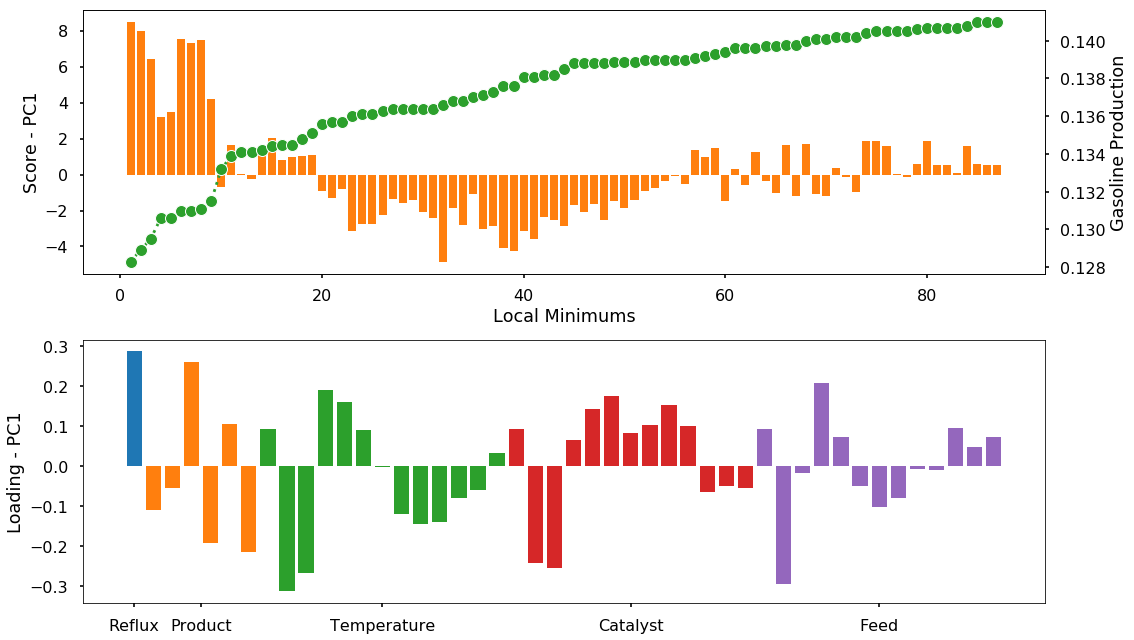

In [48]:
fig, axs = plt.subplots(2,1,figsize=(16,9))

'''
Scores
'''
x_loc = np.arange(1,len(scores[:,0])+1)
axs[0].bar(x_loc,scores[:,0],color = 'C1')

axs_ = axs[0].twinx()
axs_.plot(x_loc,opt_results_unique[:,4],'C2:o',markeredgecolor='w',markeredgewidth = 1,markersize=12)

# axs[1].legend()
axs[0].set_xlabel('Local Minimums')
axs[0].set_ylabel('Score - PC1')
axs_.set_ylabel('Gasoline Production')

'''
Loading
'''
x_loc = np.arange(1,len(pca.components_[0])+1)
grouping = {'Reflux':slice(0,1),'Product':slice(1,7),'Temperature':slice(7,20),\
            'Catalyst':slice(20,33),'Feed':slice(33,None)}

for key in grouping:
    axs[1].bar(x_loc[grouping[key]],pca.components_[0][grouping[key]])
axs[1].set_xticks([1,4.5,14,27,40])
axs[1].set_xticklabels(list(grouping.keys()))

axs[1].set_ylabel('Loading - PC1')

plt.tight_layout()
plt.show()
plt.close()

### Predictions using pre-optimization data

In [49]:
opt_origin_scaled = StandardScaler().fit_transform(opt_origin_matrix)

In [50]:
predicted_scores = pca.transform(opt_origin_scaled)

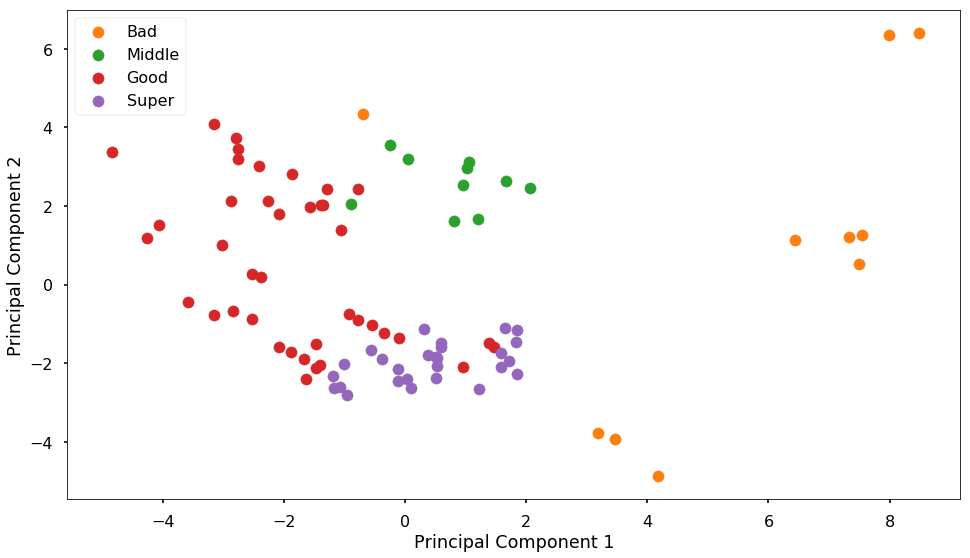

In [51]:
fig, axs = plt.subplots(figsize=(16,9))

targets = ['Bad','Middle','Good','Super']
colors = ['C1', 'C2','C3','C4']
masks = {'Bad':[[0,0.132],slice(0,10),80],\
         'Middle':[[0.1341,0.1395],slice(10,20),10],\
         'Good':[[0.1396,0.1408],slice(20,60),10],\
         'Super':[[0.1409,0.15],slice(60,87),80]}

for target, color in zip(targets,colors):
    mask = masks[target]
    axs.scatter(scores[:,0][mask[1]],scores[:,1][mask[1]],color=color,label=target)
    tmp = [j for j,run in enumerate(opt_results_matrix) if run[4] >= mask[0][0] and run[4] <= mask[0][1]]

axs.legend()
axs.set_xlabel('Principal Component 1')
axs.set_ylabel('Principal Component 2')

plt.show()
plt.close()

### Separating between "Middle" and "Good" will involve 3rd and 4th component

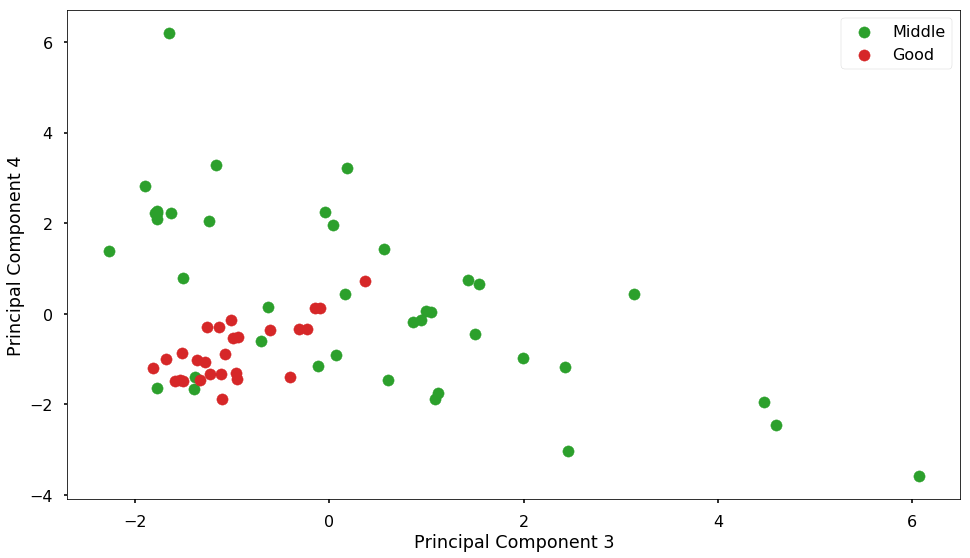

In [52]:
fig, axs = plt.subplots(figsize=(16,9))

targets = ['Middle','Good']
colors = ['C2','C3']
masks = {'Middle':[[0.1341,0.1395],slice(20,60),20],\
         'Good':[[0.1396,0.1408],slice(60,87),20]}

for target, color in zip(targets,colors):
    mask = masks[target]
    axs.scatter(scores[:,2][mask[1]],scores[:,3][mask[1]],color=color,label=target)
    tmp = [j for j,run in enumerate(opt_results_matrix) if run[4] >= mask[0][0] and run[4] <= mask[0][1]]

axs.legend()
axs.set_xlabel('Principal Component 3')
axs.set_ylabel('Principal Component 4')

plt.show()
plt.close()

---

# Lastly, optimization results, Diesel

In [53]:
obj_list = []
opt_results = []
opt_origin_results = []

for j_,j in enumerate(total_runs):
    if finished_diesel[j_]:
        file_name = 'mul_onestep_Preset_Case:_{}_NCP.dat'.format(j)
        with open('./log/text/'+file_name) as f:
            log_content = f.readlines()
            counter = 0
            
            for j, line in enumerate(reversed(log_content)):
                # get the right position, i know it is bad coding, but dont want make too much changes to the old code
                if '> One-step Optimization - Diesel' in line:
                    starter_position = j - 50            
            
            
            for j, line in enumerate(reversed(log_content)):

                if j <= starter_position:
                    continue
                
                if line.startswith('diesel'):
                    start = 'Wet flow  :'
                    end = 'Dry flow'
                    string = line[line.find(start)+len(start):line.rfind(end)]
                    string = string.strip()
                    obj_list.append(float(string))
                    j += 1
                    break
            opt_results.append(log_content[-j-30:-j-29]+log_content[-j-20:-j-7]+log_content[-j-1:-j+1])
            opt_origin_results.append(log_content[-j-80:-j-79]+log_content[-j-70:-j-57]+log_content[-j-51:-j-49])
            
opt_results = [[data.split() for data in case] for case in opt_results]
opt_origin_results = [[data.split() for data in case] for case in opt_origin_results]

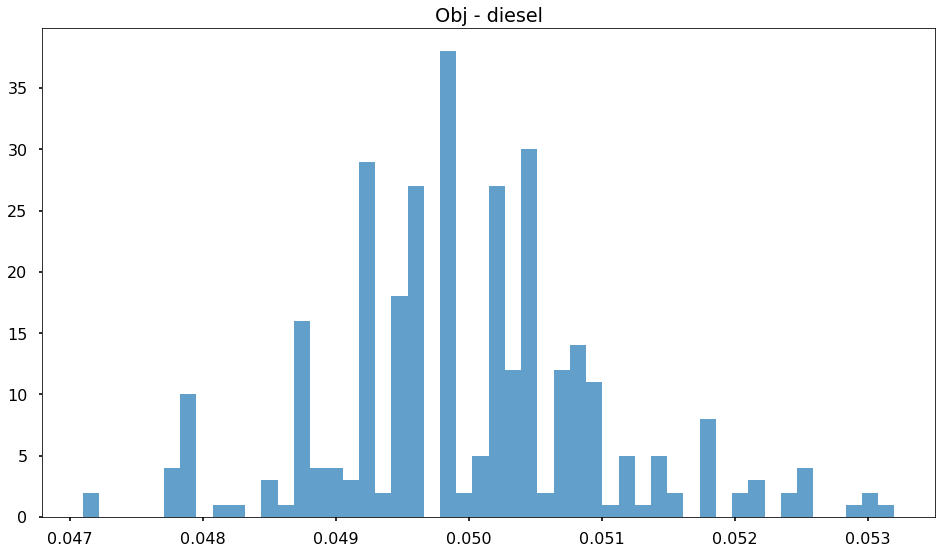

In [54]:
fig, axs = plt.subplots(figsize=(16,9))
y, bins, patches = axs.hist(obj_list,bins=50,histtype='bar',alpha=0.7)

axs.set_title('Obj - diesel')
plt.show()

### Remove duplicates and sort

In [55]:
opt_results_matrix = np.stack((
    [float(case[0][4])/float(case[0][5]) for case in opt_results],
    [float(case[-3][-1]) for case in opt_results],
    [float(case[-3][6]) for case in opt_results],
    [float(case[-2][-1]) for case in opt_results],
    [float(case[-2][6]) for case in opt_results],
    [float(case[-1][-1]) for case in opt_results],
    [float(case[-1][6]) for case in opt_results],
    *np.array([[float(obv[1]) for obv in case[1:14]] for case in opt_results]).T,
    *np.array([[float(obv[6]) for obv in case[1:14]] for case in opt_results]).T,
    *np.array([[float(obv[5]) for obv in case[1:14]] for case in opt_results]).T
),axis=1)

In [56]:
opt_results_unique_unsorted, unique_index, unique_counts = np.unique(opt_results_matrix,axis=0,return_index=True,return_counts=True)

In [57]:
unique_global_index = [np.array(total_runs)[finished_gasoline][j] for j in unique_index]
opt_results_unique = np.array(sorted(opt_results_unique_unsorted,key=lambda x: x[4]))

In [58]:
pd.options.display.precision = 4
pd.DataFrame(sorted([i for i in zip(opt_results_unique_unsorted[:,4],unique_counts,unique_global_index)],\
                    key=lambda x: x[0]),columns=['Objective Value','Occurances','Example Index'])

,Objective Value,Occurances,Example Index
0,0.0007,1,748
1,0.0007,1,66
2,0.0007,1,4
3,0.0007,1,724
4,0.0007,1,683
5,0.0007,3,41
6,0.0007,1,422
7,0.0007,1,403
8,0.0007,2,227
9,0.0007,1,270


### Raw Data

In [59]:
pd.options.display.expand_frame_repr = False
pd.options.display.max_colwidth = 80000
pd.options.display.max_columns = None
pd.options.display.max_rows = 80000

In [60]:
pd.options.display.precision = 0
pd.DataFrame(opt_results_unique[:,7:20].T,index=['Tem{}'.format(j) for j in range(8,21)])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154
Tem8,200,200,200,205,205,205,205,205,205,208,208,204,208,207,211,209,201,206,206,205,205,205,206,208,208,208,205,205,212,208,208,208,207,208,210,210,210,209,210,210,210,229,209,210,210,210,210,211,211,211,211,204,204,207,206,208,208,208,208,207,207,208,208,208,210,208,210,210,210,212,212,214,224,209,209,209,211,211,213,211,211,213,209,211,211,206,210,209,209,209,208,210,210,210,210,211,211,211,230,230,210,211,211,201,216,211,211,212,212,212,212,211,211,216,210,211,211,224,224,212,212,213,213,213,213,216,212,213,231,231,231,231,213,214,214,212,217,216,216,215,214,214,214,215,215,215,217,217,231,217,217,219,219,220,218
Tem9,214,218,220,216,216,216,216,216,216,226,225,220,217,217,221,219,222,217,217,216,216,216,217,226,226,226,220,221,222,218,218,218,218,218,226,226,226,226,226,226,226,225,219,220,220,220,220,226,226,226,226,232,232,223,220,225,225,226,226,223,231,219,220,221,226,220,226,226,226,223,222,231,226,219,220,220,222,226,223,226,226,223,220,226,226,232,230,226,226,226,226,223,226,226,226,226,226,226,236,234,221,222,222,226,231,222,223,226,226,226,226,226,226,231,227,227,227,224,224,226,226,227,226,226,226,231,228,233,250,250,250,247,226,236,236,226,233,232,231,233,229,231,226,227,227,236,228,228,252,239,239,233,233,229,236
Tem10,226,224,231,226,226,226,226,226,226,226,226,231,226,226,231,226,232,226,226,226,226,226,226,228,226,226,228,231,231,226,226,226,226,226,226,226,226,226,226,226,226,232,226,226,226,226,226,226,226,226,226,239,239,240,227,227,227,223,223,232,234,227,226,233,226,226,226,226,226,232,232,234,223,226,226,226,226,226,231,226,226,231,226,226,227,249,229,224,224,224,228,227,227,227,227,227,223,223,253,250,227,226,226,227,234,235,235,226,226,226,226,226,223,234,223,243,243,208,208,223,223,228,227,227,227,236,224,228,272,272,272,266,223,229,229,246,254,251,240,228,245,228,223,223,223,228,224,224,272,229,229,254,254,224,266
Tem11,226,232,233,226,226,226,226,226,226,223,226,232,226,226,232,226,242,227,227,226,226,226,223,227,223,223,232,236,235,226,226,226,226,226,226,226,226,226,223,223,223,242,231,226,238,226,226,226,226,226,226,254,254,229,223,223,223,208,210,243,243,240,226,226,227,223,223,223,223,243,241,243,209,226,226,226,223,226,237,226,226,237,223,223,223,264,224,210,210,210,223,223,223,223,223,223,208,211,270,265,241,226,226,223,240,226,226,226,226,223,223,223,208,241,228,229,229,239,239,212,212,228,223,223,223,244,228,223,280,280,280,272,213,224,224,223,270,264,253,224,229,252,213,231,231,223,230,230,276,224,224,270,270,230,270
Tem12,226,236,241,227,226,223,223,223,223,210,223,237,226,226,237,226,256,223,223,223,223,223,208,223,209,209,244,244,241,226,223,223,223,223,223,223,223,223,210,210,210,256,237,226,226,223,223,226,223,223,223,270,270,224,212,213,213,217,238,256,256,228,223,223,223,209,210,210,214,256,253,256,220,223,223,223,210,223,245,223,223,245,209,211,209,263,232,241,241,241,233,214,214,214,214,214,219,239,272,264,251,223,223,213,249,223,223,223,223,211,215,214,220,253,290,224,224,286,286,242,242,224,215,215,215,257,293,235,223,223,223,223,240,234,234,237,268,261,264,216,224,224,243,290,290,236,292,292,223,234,234,268,268,291,223
Tem13,223,244,253,223,223,210,210,210,210,214,211,245,223,223,245,223,270,215,215,214,214,214,220,215,220,219,257,257,249,223,211,211,215,215,212,212,212,215,221,221,221,270,242,223,223,212,212,223,212,212,212,267,267,234,243,243,243,248,281,269,269,255,216,215,216,221,221,221,240,269,264,270,249,215,216,216,222,216,257,216,216,257,221,221,221,223,291,284,284

In [61]:
pd.options.display.precision = 0
pd.DataFrame(opt_results_unique[:,20:33].T,index=['Catalyst {}'.format(j) for j in range(8,21)])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154
Catalyst 8,11,10,10,74,69,73,73,73,73,99,99,10,61,64,51,55,10,78,78,77,77,77,78,104,102,103,10,10,51,64,63,63,67,67,84,84,84,88,86,86,86,633,10,57,57,57,57,74,72,72,73,10,10,94,84,102,102,102,103,10,10,68,66,71,84,67,83,83,85,54,54,73,755,60,60,60,60,75,48,75,75,48,61,74,75,10,105,96,96,96,102,73,80,80,80,79,79,78,639,718,61,60,60,67,62,64,64,71,71,70,71,75,74,66,86,79,79,1226,1226,71,71,63,65,65,65,63,75,94,598,598,598,692,63,93,93,72,62,65,62,74,69,76,55,56,56,86,47,47,594,84,84,50,50,34,65
Catalyst 9,57,31,42,45,47,44,44,44,44,1332,933,40,38,39,38,32,36,40,40,44,44,45,39,1015,987,1413,32,37,35,35,34,35,34,34,1004,1006,1006,1274,1824,1824,1821,10,30,28,28,28,28,711,1279,1279,1277,593,593,53,30,468,468,1456,1352,32,601,31,29,44,690,28,1434,1432,1442,30,33,595,1757,30,27,27,21,1299,30,1317,1319,30,26,2096,3199,659,10,1128,1128,1128,12,17,1063,1002,1002,1002,1954,1872,10,10,24,21,21,750,449,42,42,974,974,1713,1717,1978,3056,674,1088,47,47,28663,28663,1223,1222,391,1277,1277,1277,595,1000,10,10,10,10,10,2181,10,10,1060,578,660,672,10,40,10,1527,1060,1060,10,978,978,10,10,10,574,574,962,581
Catalyst 10,1056,24,668,774,1067,1488,1490,1491,1491,2029,1665,589,1359,1410,588,1569,586,1075,1076,1508,1508,1506,2022,10,1720,2069,14,591,442,1079,1810,1807,1831,1833,1570,1573,1573,1777,2275,2275,2271,10,18,1295,1778,2035,2039,1165,1719,1719,1717,10,10,10,1322,1187,1187,28341,28444,591,10,419,1417,10,1265,2404,1922,1932,1879,590,670,10,27386,2306,2063,2063,2675,1715,592,1732,1735,593,3123,2430,10,10,974,28674,28674,28674,1050,1776,1438,1414,1414,1414,27866,27949,10,10,360,1657,1657,1244,10,10,10,1414,1414,2093,2046,2290,26770,10,28725,10,10,10,10,28606,28606,649,1593,1594,1593,10,28825,1028,10,10,10,10,27655,961,961,10,10,10,10,993,10,960,28316,28783,28783,1015,28875,28875,10,952,952,10,10,28904,10
Catalyst 11,1579,590,10,1274,1576,1938,1941,1941,1941,26448,2052,10,1743,1766,10,1871,10,1438,1438,1895,1895,1892,27770,1535,27100,26323,595,10,10,1456,2127,2124,2091,2095,1879,1882,1882,2020,25724,25724,25731,10,441,1593,10,2266,2270,1454,1955,1955,1952,10,10,961,28473,28151,28151,10,10,10,10,10,1662,2232,1487,27410,26470,26461,26502,10,10,10,10,2475,2245,2245,27153,1902,10,1915,1918,10,26699,25309,26625,10,28820,10,10,10,28745,28043,27327,27413,27413,27412,10,10,10,10,10,1827,1827,27848,10,2482,2487,1572,1572,26032,26074,25566,10,10,10,950,950,10,10,10,10,1000,26973,26972,26973,10,10,28776,10,10,10,10,10,28845,28846,28767,10,10,10,28833,942,10,10,10,10,28797,10,10,10,28864,28864,10,10,10,10
Catalyst 12,1877,10,10,1478,1872,26375,26370,26370,26370,10,25170,10,1956,1924,10,2027,10,27287,27287,26394,26394,26399,10,27255,10,10,10,10,10,1584,25884,25890,25896,25890,25381,25374,25374,24758,10,10,10,10,10,1671,2148,25532,25525,1524,24892,24892,24900,10,10,28802,10,10,10,10,10,10,10,934,26744,27562,26393,10,10,10,10,10,10,10,10,25047,25524,25524,10,24926,10,24879,24871,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,26355,26355,10,10,27321,27316,25888,25889,10,10,10,10,10,10,28834,28834,10,10,10,10,27815,10,10,10,10,10,10,29292,29292,29292,29197,10,10,10,10,10,10,10,10,28858,28864,10,10,10,10,10,10,29296,10,10,10,10,10,29254
Catalyst 13,25348,10,10,26283,25298,10,10,10,10,10,10,10,24771,24725,10,24373,10,10,10,10,10,10,10,10,10,10,10,10,10,25710,10,10,10,10,10,10,10,10,10,10,10,10,10,25283,25907,10,10,25000,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,29230,10,10,10,10,10,10

In [62]:
pd.options.display.precision = 2
pd.DataFrame(opt_results_unique[:,33:].T,index=['Feed {}'.format(j) for j in range(8,21)]).round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154
Feed 8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Feed 9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.17,0.17,0.21,0.31,0.31,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.22,0.22,0.22,0.00,0.00,0.00,0.00,0.08,0.08,0.05,0.03,0.00,0.00,0.00,0.00,0.00,0.12,0.00,0.24,0.24,0.24,0.00,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.22,0.00,0.22,0.22,0.00,0.00,0.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.18,0.17,0.17,0.17,0.13,0.12,0.00,0.00,0.00,0.00,0.00,0.12,0.00,0.00,0.00,0.16,0.16,0.29,0.29,0.34,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.02,0.07,0.22,0.22,0.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00
Feed 10,0.18,0.00,0.00,0.13,0.18,0.25,0.26,0.26,0.26,0.14,0.29,0.00,0.23,0.24,0.00,0.26,0.00,0.18,0.18,0.26,0.26,0.26,0.15,0.17,0.10,0.15,0.00,0.00,0.00,0.18,0.31,0.31,0.31,0.31,0.27,0.27,0.27,0.31,0.18,0.18,0.18,0.00,0.00,0.22,0.30,0.35,0.35,0.20,0.30,0.30,0.30,0.00,0.00,0.01,0.04,0.01,0.01,0.00,0.00,0.00,0.00,0.07,0.24,0.00,0.22,0.21,0.13,0.13,0.12,0.00,0.00,0.00,0.00,0.39,0.35,0.35,0.26,0.30,0.00,0.30,0.30,0.00,0.32,0.21,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.11,0.06,0.05,0.05,0.05,0.00,0.00,0.00,0.00,0.06,0.29,0.29,0.02,0.00,0.00,0.00,0.25,0.25,0.16,0.15,0.18,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.12,0.08,0.08,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Feed 11,0.28,0.00,0.00,0.22,0.28,0.13,0.13,0.13,0.13,0.00,0.14,0.00,0.30,0.31,0.00,0.33,0.00,0.06,0.06,0.12,0.12,0.12,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.26,0.16,0.16,0.16,0.16,0.12,0.12,0.12,0.14,0.00,0.00,0.00,0.00,0.00,0.28,0.01,0.19,0.19,0.26,0.14,0.14,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.09,0.19,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.18,0.18,0.00,0.12,0.00,0.13,0.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.12,0.00,0.00,0.23,0.23,0.08,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Feed 12,0.12,0.00,0.00,0.06,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14,0.13,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.18,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

# Analysis

In [63]:
center_scaled = StandardScaler().fit_transform(opt_results_unique)
pca = PCA(n_components=10)
scores = pca.fit_transform(center_scaled)

### Eigenvalues

In [64]:
pca.explained_variance_

array([9.06337531, 4.22729609, 3.17660619, 2.8012894 , 2.19573401,
       2.11231557, 1.93938753, 1.68631187, 1.56522137, 1.36970402])

### Captured Covariance

In [65]:
pca.explained_variance_ratio_

array([0.22512255, 0.10500058, 0.0789028 , 0.06958041, 0.0545392 ,
       0.05246719, 0.04817188, 0.04188581, 0.03887808, 0.03402168])

In [66]:
sum(pca.explained_variance_ratio_[:5])

0.5331455412374997

### A strong corrolation between PC1 and optimized objective value

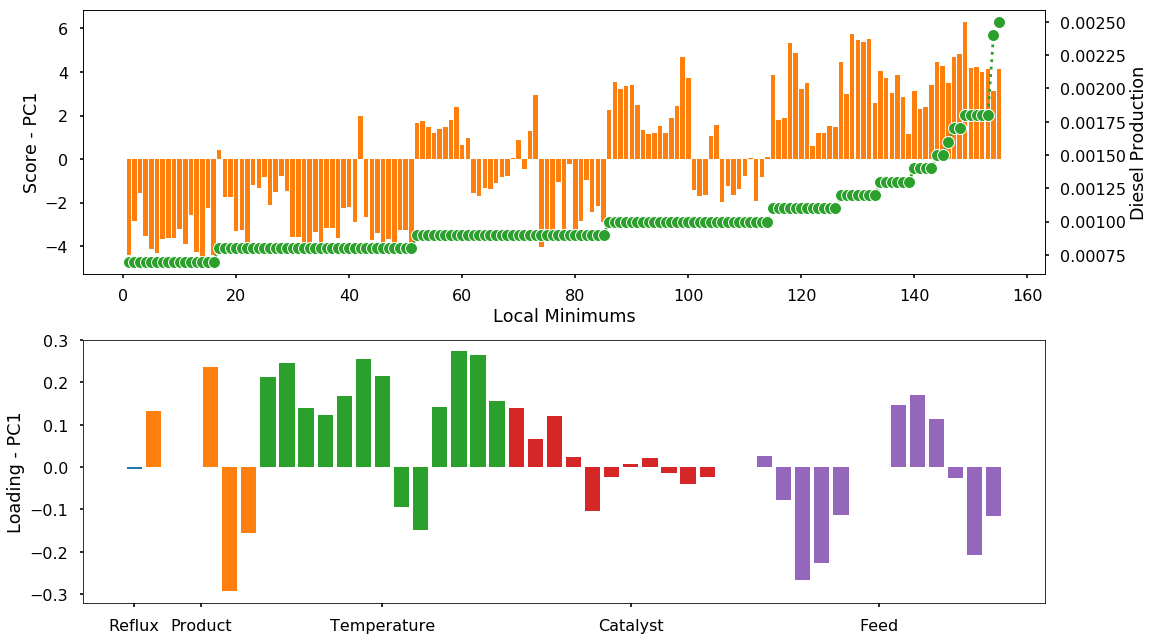

In [67]:
fig, axs = plt.subplots(2,1,figsize=(16,9))

'''
Scores
'''
x_loc = np.arange(1,len(scores[:,0])+1)
axs[0].bar(x_loc,scores[:,0],color = 'C1')

axs_ = axs[0].twinx()
axs_.plot(x_loc,opt_results_unique[:,4],'C2:o',markeredgecolor='w',markeredgewidth = 1,markersize=12)

# axs[1].legend()
axs[0].set_xlabel('Local Minimums')
axs[0].set_ylabel('Score - PC1')
axs_.set_ylabel('Diesel Production')

'''
Loading
'''
x_loc = np.arange(1,len(pca.components_[0])+1)
grouping = {'Reflux':slice(0,1),'Product':slice(1,7),'Temperature':slice(7,20),\
            'Catalyst':slice(20,33),'Feed':slice(33,None)}

for key in grouping:
    axs[1].bar(x_loc[grouping[key]],pca.components_[0][grouping[key]])
axs[1].set_xticks([1,4.5,14,27,40])
axs[1].set_xticklabels(list(grouping.keys()))

axs[1].set_ylabel('Loading - PC1')

plt.tight_layout()
plt.show()
plt.close()

In [68]:
opt_origin_scaled = StandardScaler().fit_transform(opt_origin_matrix)

In [69]:
predicted_scores = pca.transform(opt_origin_scaled)

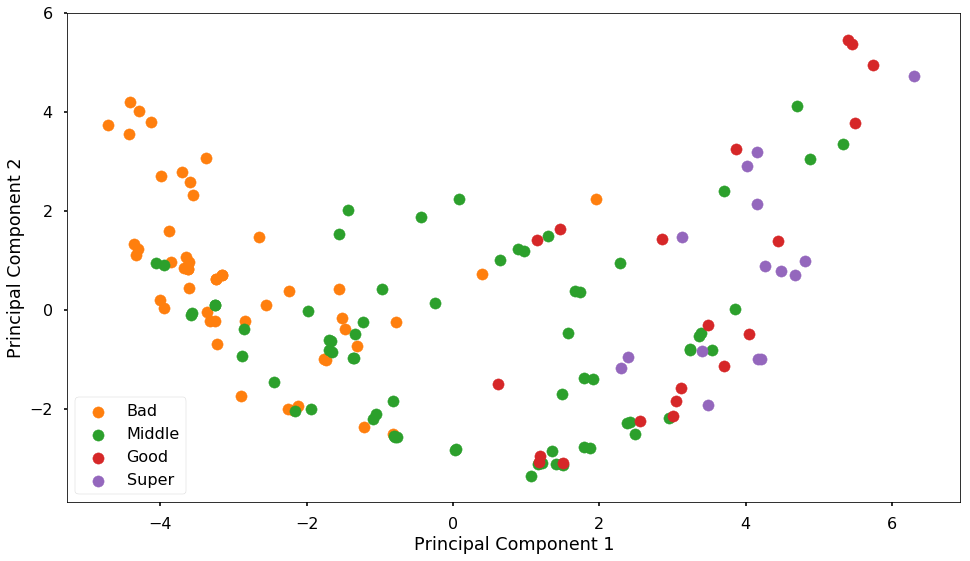

In [70]:
fig, axs = plt.subplots(figsize=(16,9))

targets = ['Bad','Middle','Good','Super']
colors = ['C1', 'C2','C3','C4']
masks = {'Bad':[[0,0.132],slice(0,50),80],\
         'Middle':[[0.1341,0.1395],slice(50,120),10],\
         'Good':[[0.1396,0.1408],slice(120,140),10],\
         'Super':[[0.1409,0.15],slice(140,155),80]}

for target, color in zip(targets,colors):
    mask = masks[target]
    axs.scatter(scores[:,0][mask[1]],scores[:,1][mask[1]],color=color,label=target)
    tmp = [j for j,run in enumerate(opt_results_matrix) if run[4] >= mask[0][0] and run[4] <= mask[0][1]]

axs.legend()
axs.set_xlabel('Principal Component 1')
axs.set_ylabel('Principal Component 2')

plt.show()
plt.close()

---

# Lastly, optimization results, Combined

In [71]:
obj_list = []
opt_results = []
opt_origin_results = []

for j_,j in enumerate(total_runs):
    if finished_combined[j_]:
        file_name = 'mul_onestep_Preset_Case:_{}_NCP.dat'.format(j)
        with open('./log/text/'+file_name) as f:
            log_content = f.readlines()
            counter = 0
            tmp_number = 0
            for j, line in enumerate(reversed(log_content)):
                
                if line.startswith('diesel'):
                    start = 'Wet flow  :'
                    end = 'Dry flow'
                    string = line[line.find(start)+len(start):line.rfind(end)]
                    string = string.strip()
                    tmp_number += float(string)               

                if line.startswith('gasoline'):
                    start = 'Wet flow  :'
                    end = 'Dry flow'
                    string = line[line.find(start)+len(start):line.rfind(end)]
                    string = string.strip()
                    tmp_number += float(string) 
                    
                if line.startswith('naphtha'):
                    start = 'Wet flow  :'
                    end = 'Dry flow'
                    string = line[line.find(start)+len(start):line.rfind(end)]
                    string = string.strip()
                    tmp_number += float(string) 
                    obj_list.append(tmp_number)
                    j -= 1
                    break
                    
            opt_results.append(log_content[-j-30:-j-29]+log_content[-j-20:-j-7]+log_content[-j-1:-j+1])
            opt_origin_results.append(log_content[-j-80:-j-79]+log_content[-j-70:-j-57]+log_content[-j-51:-j-49])
            
opt_results = [[data.split() for data in case] for case in opt_results]
opt_origin_results = [[data.split() for data in case] for case in opt_origin_results]

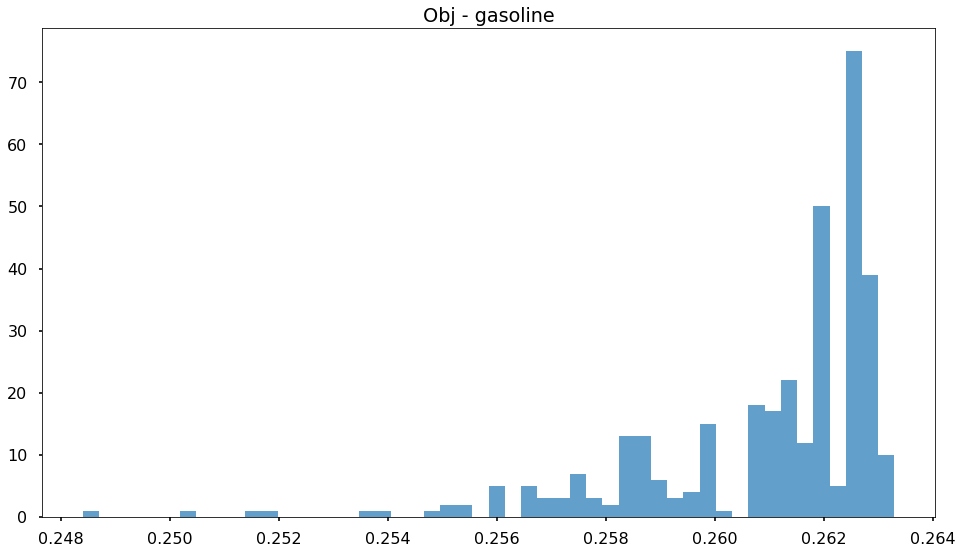

In [72]:
fig, axs = plt.subplots(figsize=(16,9))
y, bins, patches = axs.hist(obj_list,bins=50,histtype='bar',alpha=0.7)

axs.set_title('Obj - gasoline')
plt.show()

### Remove duplicates and sort

In [73]:
opt_results_matrix = np.stack((
    [float(case[0][4])/float(case[0][5]) for case in opt_results],
    [float(case[-3][-1]) for case in opt_results],
    [float(case[-3][6]) for case in opt_results],
    [float(case[-2][-1]) for case in opt_results],
    [float(case[-2][6]) for case in opt_results],
    [float(case[-1][-1]) for case in opt_results],
    [float(case[-1][6]) for case in opt_results],
    *np.array([[float(obv[1]) for obv in case[1:14]] for case in opt_results]).T,
    *np.array([[float(obv[6]) for obv in case[1:14]] for case in opt_results]).T,
    *np.array([[float(obv[5]) for obv in case[1:14]] for case in opt_results]).T
),axis=1)

In [74]:
opt_results_unique_unsorted, unique_index, unique_counts = np.unique(opt_results_matrix,axis=0,return_index=True,return_counts=True)

In [75]:
unique_global_index = [np.array(total_runs)[finished_gasoline][j] for j in unique_index]
opt_results_unique = np.array(sorted(opt_results_unique_unsorted,key=lambda x: x[4]))

In [76]:
pd.options.display.precision = 4
pd.DataFrame(sorted([i for i in zip(opt_results_unique_unsorted[:,4],unique_counts,unique_global_index)],\
                    key=lambda x: x[0]),columns=['Objective Value','Occurances','Example Index'])

,Objective Value,Occurances,Example Index
0,0.1206,1,710
1,0.1207,1,17
2,0.1208,1,212
3,0.1208,1,737
4,0.1208,1,622
5,0.1217,2,13
6,0.1229,2,256
7,0.1236,1,674
8,0.1242,1,211
9,0.1254,1,686


### Raw Data

In [77]:
pd.options.display.expand_frame_repr = False
pd.options.display.max_colwidth = 80000
pd.options.display.max_columns = None
pd.options.display.max_rows = 80000

In [78]:
pd.options.display.precision = 0
pd.DataFrame(opt_results_unique[:,7:20].T,index=['Tem{}'.format(j) for j in range(8,21)])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
Tem8,200,200,200,200,200,200,200,200,200,236,200,200,234,235,235,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200
Tem9,200,200,200,200,200,200,200,200,200,200,200,200,200,238,238,246,238,237,238,238,238,238,237,237,238,238,237,238,237,238,238,238,238,237,237,237,237,238,237,237,237,238,238,237,237,237,238,238,238,237,237,237,238,238,238,237,237,237,237,239,239,238,238,238,227,237,237,238,237,238,237,237,238,226,237,238,237,237,237,237,237,237,237,237,237
Tem10,238,200,238,237,200,237,238,200,238,238,238,238,238,200,236,240,261,249,238,238,238,245,237,262,238,230,243,231,237,238,238,237,231,237,237,237,237,237,237,237,237,231,230,237,237,237,237,237,236,237,237,237,236,236,236,237,237,236,236,236,236,237,237,237,238,237,237,237,237,237,236,236,237,238,236,237,237,237,237,237,236,236,236,236,237
Tem11,238,238,237,237,238,237,238,238,238,250,200,200,236,236,200,259,239,293,252,264,247,285,250,282,261,241,279,242,246,243,243,241,242,240,238,237,245,237,239,239,240,237,237,236,236,234,234,230,227,236,236,236,225,200,200,236,236,236,236,200,200,235,235,235,237,236,236,235,236,235,236,236,235,237,236,235,236,236,236,236,236,236,236,236,236
Tem12,237,237,237,237,237,237,237,238,237,268,238,238,201,223,233,236,258,237,237,239,288,300,297,299,238,250,295,250,290,253,253,252,251,251,277,247,281,248,250,250,251,242,241,247,247,243,244,239,235,221,221,221,234,235,235,236,234,235,235,230,230,219,219,221,235,235,235,223,235,224,236,236,224,235,236,224,235,235,235,234,236,236,236,236,236
Tem13,236,237,236,236,237,236,236,239,236,238,236,238,240,233,235,246,235,236,245,258,235,237,236,236,256,237,237,237,271,235,235,235,237,236,291,284,294,262,266,266,267,252,250,241,242,250,241,246,243,251,251,251,242,244,244,228,243,228,228,239,239,237,237,235,224,227,227,232,228,232,235,235,232,226,234,232,228,228,228,228,234,234,234,235,234
Tem14,229,236,235,236,236,235,227,251,246,236,246,248,246,239,239,238,244,242,235,235,242,235,243,236,235,235,236,235,236,244,244,244,236,244,236,264,236,235,236,236,236,242,235,236,237,237,235,261,256,241,241,241,236,236,236,250,241,251,251,241,241,245,245,242,235,238,238,237,236,234,229,229,233,200,230,233,233,232,232,232,230,230,230,234,230
Tem15,233,235,230,235,227,230,236,267,244,240,243,243,238,242,239,300,238,235,240,244,238,239,235,235,246,239,235,240,235,238,238,238,235,234,236,235,236,240,242,252,235,235,243,235,235,236,242,235,249,300,300,300,235,200,300,241,235,242,242,234,234,237,237,239,241,246,246,240,243,238,238,238,238,234,236,234,238,234,234,234,233,233,233,231,233
Tem16,234,230,233,231,238,237,244,237,236,238,236,237,200,237,236,232,200,240,237,238,236,300,241,241,239,237,240,237,240,200,300,236,240,238,234,240,235,237,234,234,240,240,238,240,240,234,238,240,246,300,300,200,240,200,300,300,241,300,300,200,200,300,300,235,238,238,238,236,239,239,246,246,238,238,243,238,241,238,238,238,238,238,237,234,235
Tem17,239,237,238,237,246,244,240,235,242,200,242,244,200,235,235,222,200,237,200,200,200,217,200,214,236,236,237,200,237,200,227,200,237,237,239,237,240,236,239,239,237,236,236,237,237,239,200,237,246,200,300,300,237,200,206,232,238,229,300,200,200,300,300,200,235,300,200,234,235,235,238,238,236,239,239,237,237,240,240,238,241,241,239,238,239


In [79]:
pd.options.display.precision = 0
pd.DataFrame(opt_results_unique[:,20:33].T,index=['Catalyst {}'.format(j) for j in range(8,21)])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
Catalyst 8,10,10,10,10,10,10,10,10,10,14386,10,10,8547,8531,8707,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
Catalyst 9,10,10,10,10,10,10,10,10,10,10,10,10,10,9224,9133,10,1474,4826,13853,1447,5162,3798,1668,1191,2928,13767,3699,14589,3778,4787,4791,6726,14287,6190,2193,5059,2320,8438,6925,6821,6454,7455,8319,7694,8436,5994,9827,9523,11961,7787,7772,7758,10645,11642,11641,8806,8409,6549,6549,12069,12068,8687,8687,9142,27,6996,6994,9347,7416,9499,5907,5905,9637,28,6295,9742,7566,7678,7677,7806,6397,6395,6527,5580,6489
Catalyst 10,6552,10,5009,3908,10,4971,6438,10,7128,10,12381,11879,7760,10,12058,10733,10,10,10,1633,8075,10,7496,10,2994,10,10,10,6665,13824,13809,12621,10,10999,2348,4776,3534,12111,11334,11350,12550,10,10,13058,13972,11960,14316,13319,13766,6690,6679,6668,14119,18247,18248,8662,7328,5987,5987,17820,17821,7518,7518,7838,9335,6376,6374,8000,6688,8272,5541,5539,8518,9562,5847,8698,6791,6862,6862,6954,5919,5918,6019,5269,5981
Catalyst 11,6935,5618,5785,4876,6395,5648,6658,5558,6700,10,10,10,13591,12144,10,10,10605,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,1694,7421,10,10,10,10,10,12219,12293,10,10,10,10,10,10,15420,15446,15468,10,10,10,10,10681,4678,4678,10,10,13693,13693,12919,7836,5340,5339,12551,5576,12128,4877,4875,11743,8210,5104,11459,5678,5905,5902,6149,5156,5155,5224,4707,5193
Catalyst 12,6139,5788,5493,4881,6379,5382,5910,10932,10713,10,11049,9865,10,10,10,19156,10,4071,4963,10101,10,10,10,10,9773,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,12430,10,12694,12694,10,10,10,10,10,12712,11196,11201,10,10228,10,3989,3988,10,12108,4190,10,9874,9463,9467,8999,4264,4263,4400,4070,4378
Catalyst 13,10282,5276,4754,4470,5575,4652,10902,10,10,5254,10,10,10,10,10,10,17819,8123,10,10,16662,8644,9247,6871,10,4994,5591,4332,10,11287,11299,10551,2449,3728,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,9604,9610,10,10,8481,10,10,10,10,10,8181,8186,7747,3334,7876
Catalyst 14,10,4458,8877,3775,11560,9265,10,10,10,10259,10,10,10,10,10,10,10,10,11083,16726,10,17457,10,7903,14213,11138,6665,10977,5863,10,10,10,4016,10,4676,10,4988,9349,4210,3502,2941,300,9286,2433,2110,1536,5755,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,6967,10
Catalyst 15,10,8777,10,8018,10,10,10,10,10,10,10,10,10,10,10,10,10,12888,10,10,10,10,11496,13943,10,10,13954,10,13602,10,10,10,9156,8990,5848,12652,6004,10,10,10,7962,9934,10,6723,5390,2919,10,7057,10,10,10,10,5135,10,10,10,3491,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
Catalyst 16,10,10,10,10,10,10,10,3861,5367,10,6468,3621,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,13169,10,13072,10,7439,8234,10,10,10,10,10,7509,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
Catalyst 17,10,10,10,10,10,10,10,9557,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10


In [80]:
pd.options.display.precision = 2
pd.DataFrame(opt_results_unique[:,33:].T,index=['Feed {}'.format(j) for j in range(8,21)]).round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
Feed 8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.32,1.34,1.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Feed 9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.01,2.03,0.00,0.27,0.00,0.00,0.26,0.93,0.00,0.29,0.20,0.51,0.00,0.00,0.00,0.64,0.86,0.86,1.20,0.00,1.06,0.36,0.86,0.38,1.48,1.18,1.16,1.11,0.00,0.00,1.32,1.46,1.02,1.73,1.68,2.12,1.34,1.34,1.34,1.88,2.08,2.08,1.52,1.44,1.09,1.09,2.16,2.16,1.51,1.51,1.60,0.00,1.17,1.17,1.64,1.25,1.66,0.96,0.96,1.69,0.00,1.03,1.71,1.28,1.30,1.30,1.32,1.05,1.05,1.07,0.90,1.07
Feed 10,1.07,0.00,0.79,0.60,0.00,0.78,1.05,0.00,1.18,0.00,2.11,1.96,1.61,0.00,0.00,0.00,0.01,0.85,0.00,0.31,0.00,0.69,0.00,0.00,0.56,0.00,0.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.42,0.92,0.00,0.00,0.00,0.00,0.00,1.32,1.48,0.00,0.00,0.00,0.00,0.00,0.00,1.32,1.32,1.32,0.00,0.00,0.00,0.00,1.50,1.17,1.17,0.00,0.00,1.52,1.52,1.61,1.64,1.27,1.26,1.66,1.34,1.79,1.04,1.04,1.90,1.69,1.11,1.98,1.37,1.38,1.38,1.40,1.13,1.13,1.15,0.97,1.14
Feed 11,1.37,0.91,1.07,0.86,1.06,1.04,1.31,0.95,1.35,2.51,0.00,0.00,0.00,0.00,0.00,2.13,0.00,0.02,2.57,0.01,1.65,0.00,1.39,0.00,0.01,0.00,0.00,0.00,1.27,0.00,0.00,0.00,0.00,0.00,0.32,0.00,0.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.77,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.62,1.17,1.17,0.00,1.25,0.00,1.07,1.07,0.00,1.78,1.14,0.00,1.29,1.42,1.42,1.56,1.16,1.16,1.18,1.00,1.17
Feed 12,1.38,1.08,1.20,0.98,1.25,1.16,1.32,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,2.12,0.80,0.00,0.00,0.00,0.03,0.03,0.03,0.00,2.57,0.02,2.74,0.02,2.83,2.83,2.65,2.61,2.29,0.00,1.63,0.00,2.89,2.43,2.43,2.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.92,0.92,0.00,0.00,0.99,0.00,0.00,0.00,0.00,0.00,1.01,1.01,1.10,1.01,1.09
Feed 13,0.00,1.16,1.13,1.05,1.22,1.09,0.00,0.00,0.00,1.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.17,2.06,0.00,1.60,0.00,1.21,2.04,1.14,1.05,1.00,0.02,0.00,0.00,0.00,0.61,0.00,0.02,0.00,0.03,0.00,0.02,0.02,0.02,2.72,2.81,3.13,3.43,2.52,4.03,3.55,4.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.82,0.00
Feed 14,0.00,1.06,0.00,0.92,0.00,0.00,0.00,2.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.85,0.00,1.66,0.00,0.00,0.00,0.00,1.90,1.57,0.00,0.00,1.36,0.00,1.22,0.00,0.00,0.00,0.96,0.93,0.92,0.00,0.97,0.00,0.00,0.87,0.74,0.00,0.00,0.62,0.56,0.44,0.00,0.00,0.00,7.32,7.32,7.32,4.42,7.90,7.90,0.00,3.66,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Feed 15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,3.14,0.00,3.04,2.44,7.04,0.00,0.00,0.00,7.58,0.00,0.00,0.00,0.00,7.66,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.28,6.29,0.00,0.00,0.00,1.22,0.00,1.25,0.00,1.07,0.00,0.00,0.00,0.00,0.00,0.00,0.72,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.69,0.00,6.72,6.72,7.82,7.82,6.95,6.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Feed 16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.93,0.00,6.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.24,7.35,7.40,0.00,6.37,6.97,0.00,0.00,0.00,6.24,0.00,0.00,0.00,6.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00

# Analysis

In [81]:
center_scaled = StandardScaler().fit_transform(opt_results_unique)
pca = PCA(n_components=10)
scores = pca.fit_transform(center_scaled)

### Eigenvalues

In [82]:
pca.explained_variance_

array([6.35405018, 5.07272637, 4.15889026, 3.55787744, 2.97666342,
       2.59507482, 2.17796282, 1.90213178, 1.83274435, 1.49745768])

### Captured Covariance

In [83]:
pca.explained_variance_ratio_

array([0.13650645, 0.10897929, 0.089347  , 0.07643522, 0.06394878,
       0.05575097, 0.04678999, 0.04086421, 0.03937354, 0.03217045])

In [84]:
sum(pca.explained_variance_ratio_[:5])

0.4752167376405627

### A strong corrolation between PC1 and optimized objective value

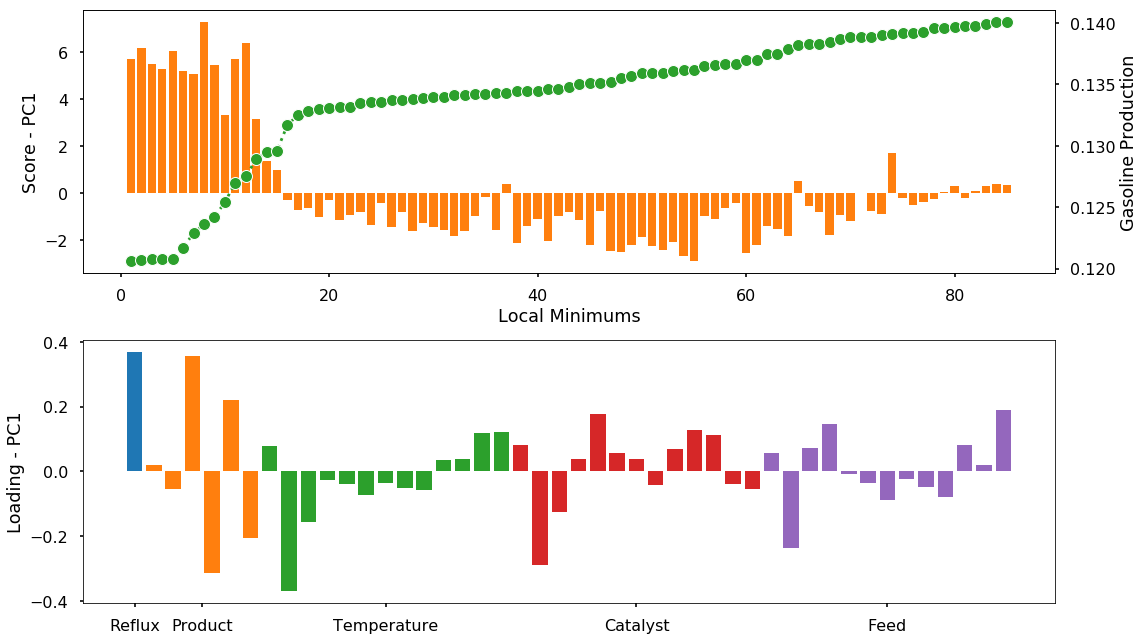

In [85]:
fig, axs = plt.subplots(2,1,figsize=(16,9))

'''
Scores
'''
x_loc = np.arange(1,len(scores[:,0])+1)
axs[0].bar(x_loc,scores[:,0],color = 'C1')

axs_ = axs[0].twinx()
axs_.plot(x_loc,opt_results_unique[:,4],'C2:o',markeredgecolor='w',markeredgewidth = 1,markersize=12)

# axs[1].legend()
axs[0].set_xlabel('Local Minimums')
axs[0].set_ylabel('Score - PC1')
axs_.set_ylabel('Gasoline Production')

'''
Loading
'''
x_loc = np.arange(1,len(pca.components_[0])+1)
grouping = {'Reflux':slice(0,1),'Product':slice(1,7),'Temperature':slice(7,20),\
            'Catalyst':slice(20,33),'Feed':slice(33,None)}

for key in grouping:
    axs[1].bar(x_loc[grouping[key]],pca.components_[0][grouping[key]])
axs[1].set_xticks([1,4.5,14,27,40])
axs[1].set_xticklabels(list(grouping.keys()))

axs[1].set_ylabel('Loading - PC1')

plt.tight_layout()
plt.show()
plt.close()

### Predictions using pre-optimization data

In [86]:
opt_origin_scaled = StandardScaler().fit_transform(opt_origin_matrix)

In [87]:
predicted_scores = pca.transform(opt_origin_scaled)

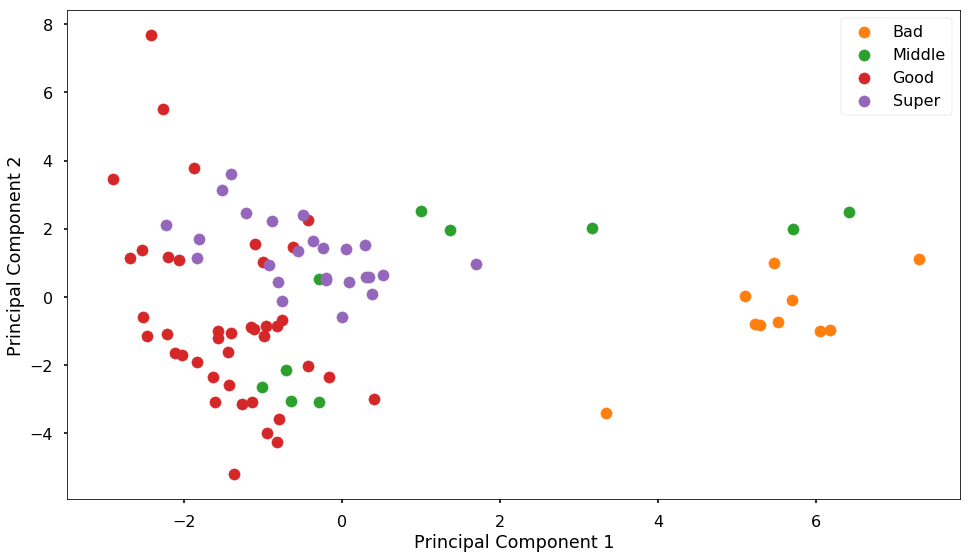

In [88]:
fig, axs = plt.subplots(figsize=(16,9))

targets = ['Bad','Middle','Good','Super']
colors = ['C1', 'C2','C3','C4']
masks = {'Bad':[[0,0.132],slice(0,10),80],\
         'Middle':[[0.1341,0.1395],slice(10,20),10],\
         'Good':[[0.1396,0.1408],slice(20,60),10],\
         'Super':[[0.1409,0.15],slice(60,87),80]}

for target, color in zip(targets,colors):
    mask = masks[target]
    axs.scatter(scores[:,0][mask[1]],scores[:,1][mask[1]],color=color,label=target)
    tmp = [j for j,run in enumerate(opt_results_matrix) if run[4] >= mask[0][0] and run[4] <= mask[0][1]]

axs.legend()
axs.set_xlabel('Principal Component 1')
axs.set_ylabel('Principal Component 2')

plt.show()
plt.close()

### Separating between "Middle" and "Good" will involve 3rd and 4th component

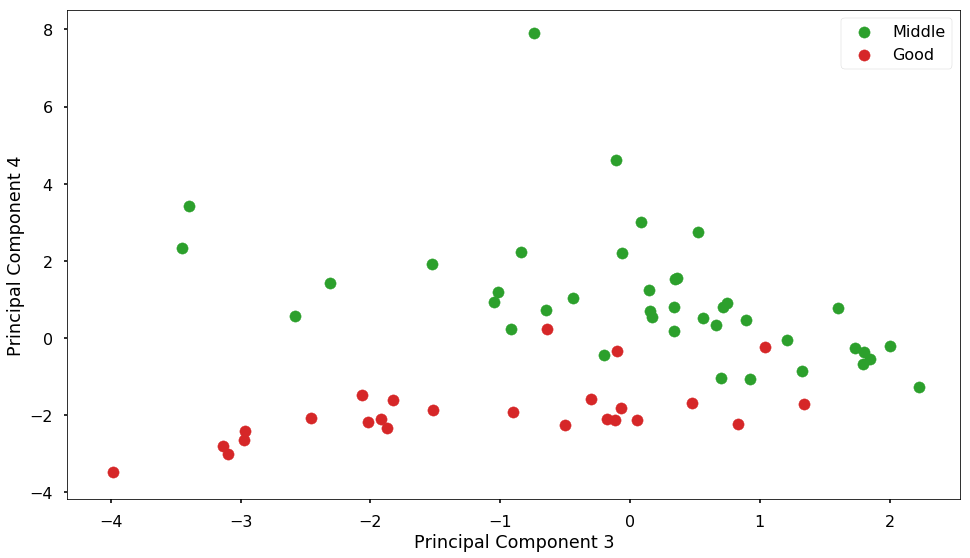

In [89]:
fig, axs = plt.subplots(figsize=(16,9))

targets = ['Middle','Good']
colors = ['C2','C3']
masks = {'Middle':[[0.1341,0.1395],slice(20,60),20],\
         'Good':[[0.1396,0.1408],slice(60,87),20]}

for target, color in zip(targets,colors):
    mask = masks[target]
    axs.scatter(scores[:,2][mask[1]],scores[:,3][mask[1]],color=color,label=target)
    tmp = [j for j,run in enumerate(opt_results_matrix) if run[4] >= mask[0][0] and run[4] <= mask[0][1]]

axs.legend()
axs.set_xlabel('Principal Component 3')
axs.set_ylabel('Principal Component 4')

plt.show()
plt.close()

---